# SNA Project - Network Comparison Between In-Person Meetings and Phone Calls in Criminal Associations

### Library imports and network loading

In [1]:
import networkx as nx   # Library for network analysis
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
# Load datasets
meetings_file = r'Dataset\Cleaned\Montagna_Meetings_Clean.csv'
df_meetings = pd.read_csv(meetings_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])
calls_file = r'Dataset\Cleaned\Montagna_Phone_Calls_Clean.csv'
df_calls = pd.read_csv(calls_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])

In [8]:
# Load roles
roles_file = r'Dataset\Cleaned\Montagna_Roles_Clean.csv'
df_roles = pd.read_csv(roles_file, names=['Node', 'Role_Raw', 'Relationship', 'Request'], header=None)
df_roles['Node'] = df_roles['Node'].astype(int) # Ensure Node column is treated as int

# Renames for clarity
df_roles.columns = ['Node', 'Role_Raw', 'Relationship', 'Request']

# Function to extract family and rank or role
def extract_role_info_full(row):
    role = row['Role_Raw']
    if pd.isna(role):
        return pd.Series({'Family': None, 'Rank': None, 'Role': None})
    
    role = role.strip().lower()
    family_match = re.search(r"(boss|member|co-founder|deputy boss|executive)?\s*(?:of\s+)?family\s*''([^']+)''",  role)
    
    if family_match:
        rank = family_match.group(1) or 'member'    # Default to 'member' if no rank is specified
        family = family_match.group(2)              # Extract family name
        return pd.Series({'Family': family.title(), 'Rank': rank.lower(), 'Role': None})
    
    # if 'boss cosa nostra' in role:
    #     return pd.Series({'Family': 'Cosa Nostra', 'Rank': 'boss', 'Role': None})
    # if 'cooperating witness' in role:
    #     return pd.Series({'Family': None, 'Rank': None, 'Role': 'cooperating witness'})
    
    return pd.Series({'Family': None, 'Rank': None, 'Role': role})

df_enriched_roles = df_roles.copy()
df_enriched_roles[['Family', 'Rank', 'Role']] = df_roles.apply(extract_role_info_full, axis=1)

role_info = df_enriched_roles.set_index('Node').to_dict('index')    # Set 'Node' as index (0-based indexing)

In [10]:
# General information about roles
# Families and their counts
families = df_enriched_roles['Family'].dropna().unique()
print(f"Families found: {len(families)}")
for family in families:
    count = df_enriched_roles[df_enriched_roles['Family'] == family].shape[0]
    print(f"Family: {family}, Count: {count}")
print("")
# Roles and their counts
print("Roles and their counts:")
role_counts = df_enriched_roles['Role'].value_counts()
for role, count in role_counts.items():
    print(f"Role: {role}, Count: {count}")

Families found: 8
Family: Barcellona Pozzo Di Gotto, Count: 2
Family: Caltagirone, Count: 1
Family: Mistretta, Count: 9
Family: Mazzaroti, Count: 3
Family: Brancaccio, Count: 1
Family: San Mauro Castelverde, Count: 1
Family: Batanesi, Count: 17
Family: Tortorici, Count: 2

Roles and their counts:
Role: enterpreneur, Count: 30
Role: lawyer, Count: 2
Role: road haulier, Count: 2
Role: farmer, Count: 1
Role: accountant employee of 113, Count: 1
Role: non-existent enterpreneur created during a scam, Count: 1
Role: walking fishmonger, Count: 1
Role: bar owner, Count: 1
Role: land owner, Count: 1
Role: cooperating witness, Count: 1
Role: car electrician, Count: 1
Role: construction worker, Count: 1
Role: intermediator, Count: 1
Role: executive family, Count: 1
Role: pharmacist-member, Count: 1
Role: boss cosa nostra in messina, Count: 1
Role: city employee, Count: 1


In [11]:
# Load networks from cleaned dataframes
G_meetings = nx.Graph(name="Meetings Network")
G_meetings.add_weighted_edges_from(df_meetings.values)
G_calls = nx.Graph(name="Calls Network")
G_calls.add_weighted_edges_from(df_calls.values)

# Add node roles to graphs
for node in G_meetings.nodes():
    if node in role_info:
        nx.set_node_attributes(G_meetings, {node: role_info[node]})
for node in G_calls.nodes():
    if node in role_info:
        nx.set_node_attributes(G_calls, {node: role_info[node]})

In [12]:
# DEBUG - Print summary of the graphs
print(f"Meetings: {G_meetings.number_of_nodes()} nodes, {G_meetings.number_of_edges()} edges")
print(f"Calls: {G_calls.number_of_nodes()} nodes, {G_calls.number_of_edges()} edges")
print(f"Nodes in common: {len(set(G_meetings.nodes()) & set(G_calls.nodes()))}")

print(G_meetings.nodes[2])  # Output: {'Role_Raw': "boss family ''Barcellona Pozzo di Gotto''", 'Relationship': nan, 'Request': nan, 'Family': 'Barcellona Pozzo Di Gotto', 'Rank': 'boss', 'Role': None}

Meetings: 95 nodes, 248 edges
Calls: 94 nodes, 120 edges
Nodes in common: 46
{'Role_Raw': "boss family ''Barcellona Pozzo di Gotto''", 'Relationship': nan, 'Request': nan, 'Family': 'Barcellona Pozzo Di Gotto', 'Rank': 'boss', 'Role': None}


In [13]:
# DEBUG - Identify self-loops
def find_self_loops(G, name="Graph"):
    loops = list(nx.selfloop_edges(G))
    print(f"{name} - Number of self-loops: {len(loops)}")
    if loops:
        print("Self-loops found at nodes:", [u for u, _ in loops])

find_self_loops(G_meetings, name="Meetings")
find_self_loops(G_calls, name="Phone Calls")

# Meetings - Number of self-loops: 1. Self-loops found at nodes: ['N47']
# After dataset cleaning:
# Meetings - Number of self-loops: 0
# Phone Calls - Number of self-loops: 0

Meetings - Number of self-loops: 0
Phone Calls - Number of self-loops: 0


In [14]:
# DEBUG - Count and print duplicate edges
duplicates = df_meetings.duplicated(subset=['Source', 'Target'], keep=False)
print(f"Duplicate edge rows in meetings: {duplicates.sum()}")
if duplicates.any():
    print(df_meetings[duplicates].sort_values(by=['Source', 'Target']))

duplicates_calls = df_calls.duplicated(subset=['Source', 'Target'], keep=False)
print(f"Duplicate edge rows in calls: {duplicates_calls.sum()}")
if duplicates_calls.any():
    print(df_calls[duplicates_calls].sort_values(by=['Source', 'Target']))
    
# With directionality:
# Duplicate edge rows in meetings: 6
#      Source  Target  Weight
# 77       22      18       2
# 142      22      18       1
# 104      43      47       1
# 161      43      47       3
# 175      47      27       2
# 180      47      27       1
#      Source  Target  Weight
# 36       43      47       1
# 37       43      47       1
# 66       66      61       3
# 119      66      61       1
# After dataset cleaning:
# Duplicate edge rows in meetings: 0
# Duplicate edge rows in calls: 0

Duplicate edge rows in meetings: 0
Duplicate edge rows in calls: 0


### Plot the separated networks

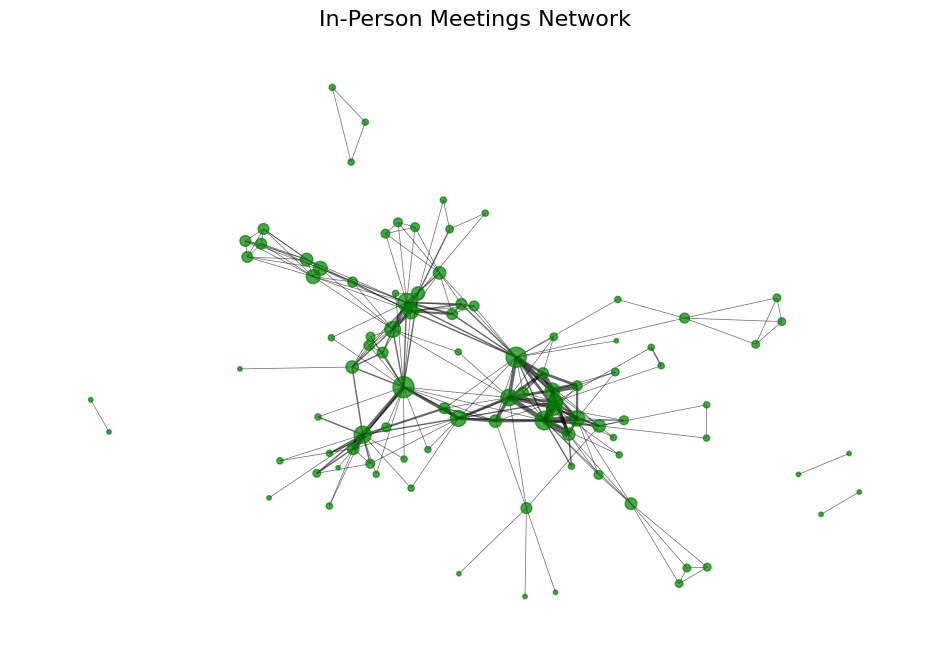

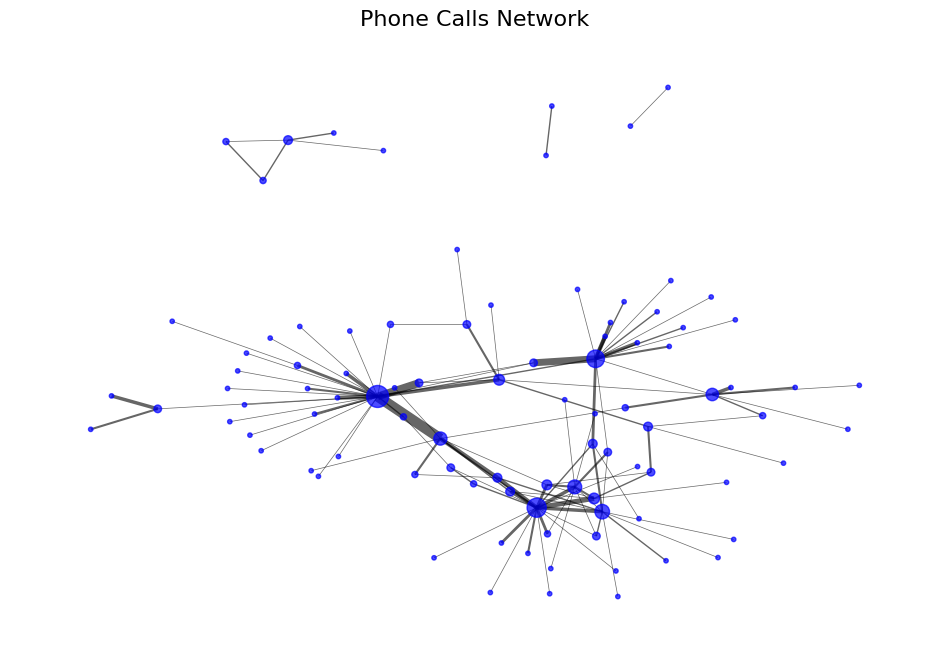

In [15]:
# Function to draw graphs. Scales node sizes by degree and edge widths by weight
def draw_graph(G, title, node_color='lightgray', edge_color='black'):
    plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * 10 for n in G.nodes()]  # Node size scaled by degree (scale factor = 10, can be adjusted)
    
    edge_weights = [G[u][v].get('weight', 1) * 0.5 for u, v in G.edges()]   # Edge width scaled by weight (scale factor = 0.5, can be adjusted)

    pos = nx.spring_layout(G, k=0.25, seed=42)  # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_color, alpha=0.6)
    #nx.draw_networkx_labels(G, pos, font_size=8)
    # If node has a role (not empty or nan), display it in the label
    labels = {
        n: f"{n}\n{data['Family']} ({data['Rank']})"
        for n, data in G.nodes(data=True)
        if 'Family' in data and 'Rank' in data  
        and pd.notna(data['Family']) and str(data['Family']).strip() != ''
        and pd.notna(data['Rank']) and str(data['Rank']).strip() != ''
    }
    #nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')
    
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

draw_graph(G_meetings, "In-Person Meetings Network", node_color='green')
draw_graph(G_calls, "Phone Calls Network", node_color='blue')

### Aggregated Graph

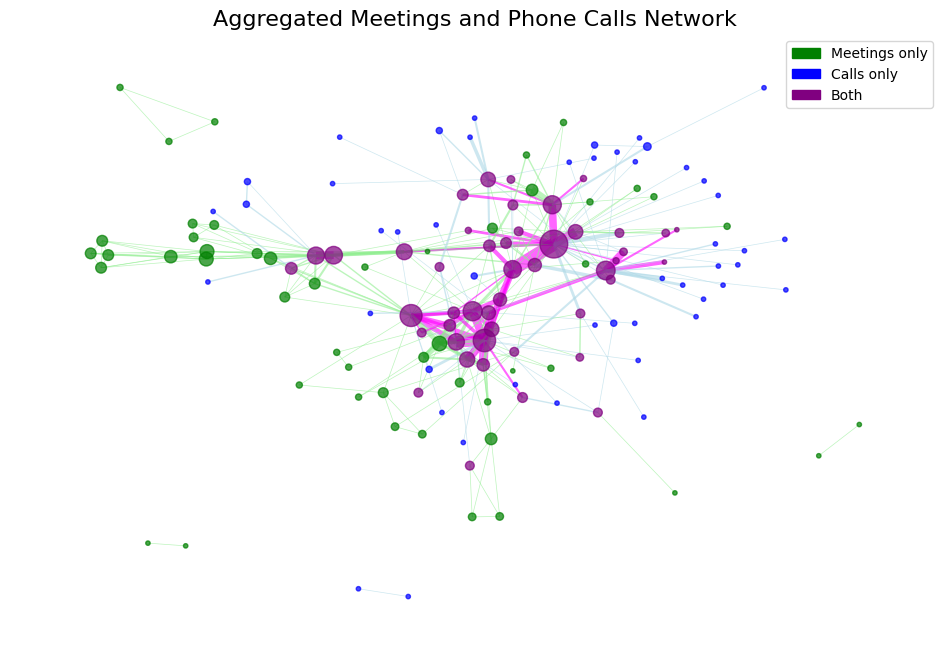

In [16]:
# Combine the two graphs in an "aggregated" graph
G_aggregated = nx.Graph(name="Aggregated Network")  # Create an empty graph for aggregation
# G_aggregated.add_edges_from(G_meetings.edges(data=True))  # data=True carries edge attributes (weights)
# G_aggregated.add_edges_from(G_calls.edges(data=True))     # Adds edges that are not already in the graph. Nodes in common are merged.

# Add meetings edges
for u, v, data in G_meetings.edges(data=True):
    w = data.get('weight', 1)
    if G_aggregated.has_edge(u, v):
        # If edge already exists, add the weight
        G_aggregated[u][v]['weight'] += w
        G_aggregated[u][v]['methods'].add('meetings')
    else:
        G_aggregated.add_edge(u, v, weight=w, methods={'meetings'})
# Add calls edges similarly
for u, v, data in G_calls.edges(data=True):
    w = data.get('weight', 1)
    if G_aggregated.has_edge(u, v):
        G_aggregated[u][v]['weight'] += w
        G_aggregated[u][v]['methods'].add('calls')
    else:
        G_aggregated.add_edge(u, v, weight=w, methods={'calls'})

# Add node roles to the aggregated graph
for node in G_aggregated.nodes():
    if node in role_info:
        nx.set_node_attributes(G_aggregated, {node: role_info[node]})

# Classify edges
edge_colors = []
for u, v in G_aggregated.edges():
    methods = G_aggregated[u][v]['methods']
    if methods == {'meetings'}:
        edge_colors.append('lightgreen')  # Meetings only
    elif methods == {'calls'}:
        edge_colors.append('lightblue')   # Calls only
    else:
        edge_colors.append('magenta') # Both

# Classify nodes
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())

node_colors = {}
for node in G_aggregated.nodes():
    in_meetings = node in nodes_meetings
    in_calls = node in nodes_calls
    if in_meetings and in_calls:
        node_colors[node] = 'purple'  # both
    elif in_meetings:
        node_colors[node] = 'green'   # only meetings
    elif in_calls:
        node_colors[node] = 'blue'    # only calls
colors_list = [node_colors[n] for n in G_aggregated.nodes()]  

# Node sizes (scaled by degree)
degrees = dict(G_aggregated.degree())
node_sizes = [degrees[n] * 10 for n in G_aggregated.nodes()]
edge_weights = [G_aggregated[u][v]['weight'] * 0.5 for u, v in G_aggregated.edges()]    # Edge thickness (scaled by weight, factor = 0.5)

pos = nx.spring_layout(G_aggregated, k=0.25, seed=42) # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
# Draw aggregated graph
nx.draw_networkx_nodes(G_aggregated, pos, node_color=colors_list, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G_aggregated, pos, width=edge_weights, edge_color=edge_colors, alpha=0.6)
#nx.draw_networkx_labels(G_aggregated, pos, font_size=8)
labels = {
        n: f"{n}\n{data['Family']} ({data['Rank']})"
        for n, data in G_aggregated.nodes(data=True)
        if 'Family' in data and 'Rank' in data  
        and pd.notna(data['Family']) and str(data['Family']).strip() != ''
        and pd.notna(data['Rank']) and str(data['Rank']).strip() != ''
    }
#nx.draw_networkx_labels(G_aggregated, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')

# Add legend
import matplotlib.patches as mpatches
legend = [mpatches.Patch(color='green', label='Meetings only'),
          mpatches.Patch(color='blue', label='Calls only'),
          mpatches.Patch(color='purple', label='Both')]
plt.legend(handles=legend)
plt.axis('off')
plt.title("Aggregated Meetings and Phone Calls Network", fontsize=16)
plt.show()

### Multilayer graph

In [17]:
# Create empty multilayer graph
G_multi = nx.Graph(name="Multilayer Network")

# Layer 0: Meetings
for u, v, data in G_meetings.edges(data=True):
    G_multi.add_edge((u, 0), (v, 0), weight=data.get('weight', 1), layer='meetings')
# Layer 1: Calls
for u, v, data in G_calls.edges(data=True):
    G_multi.add_edge((u, 1), (v, 1), weight=data.get('weight', 1), layer='calls')
# Add interlayer edges: (same person across layers)
common_nodes = set(G_meetings.nodes()) & set(G_calls.nodes())
for node in common_nodes:
    G_multi.add_edge((node, 0), (node, 1), weight=1, layer='interlayer')

# Add node roles to the multilayer graph
for node in G_multi.nodes():
    if node[0] in role_info:  # node[0] is the original node ID
        nx.set_node_attributes(G_multi, {node: role_info[node[0]]})

#test, print node data of node (2, 0)
#print(f"Node data for (2, 0): {G_multi.nodes[(2, 0)]}")

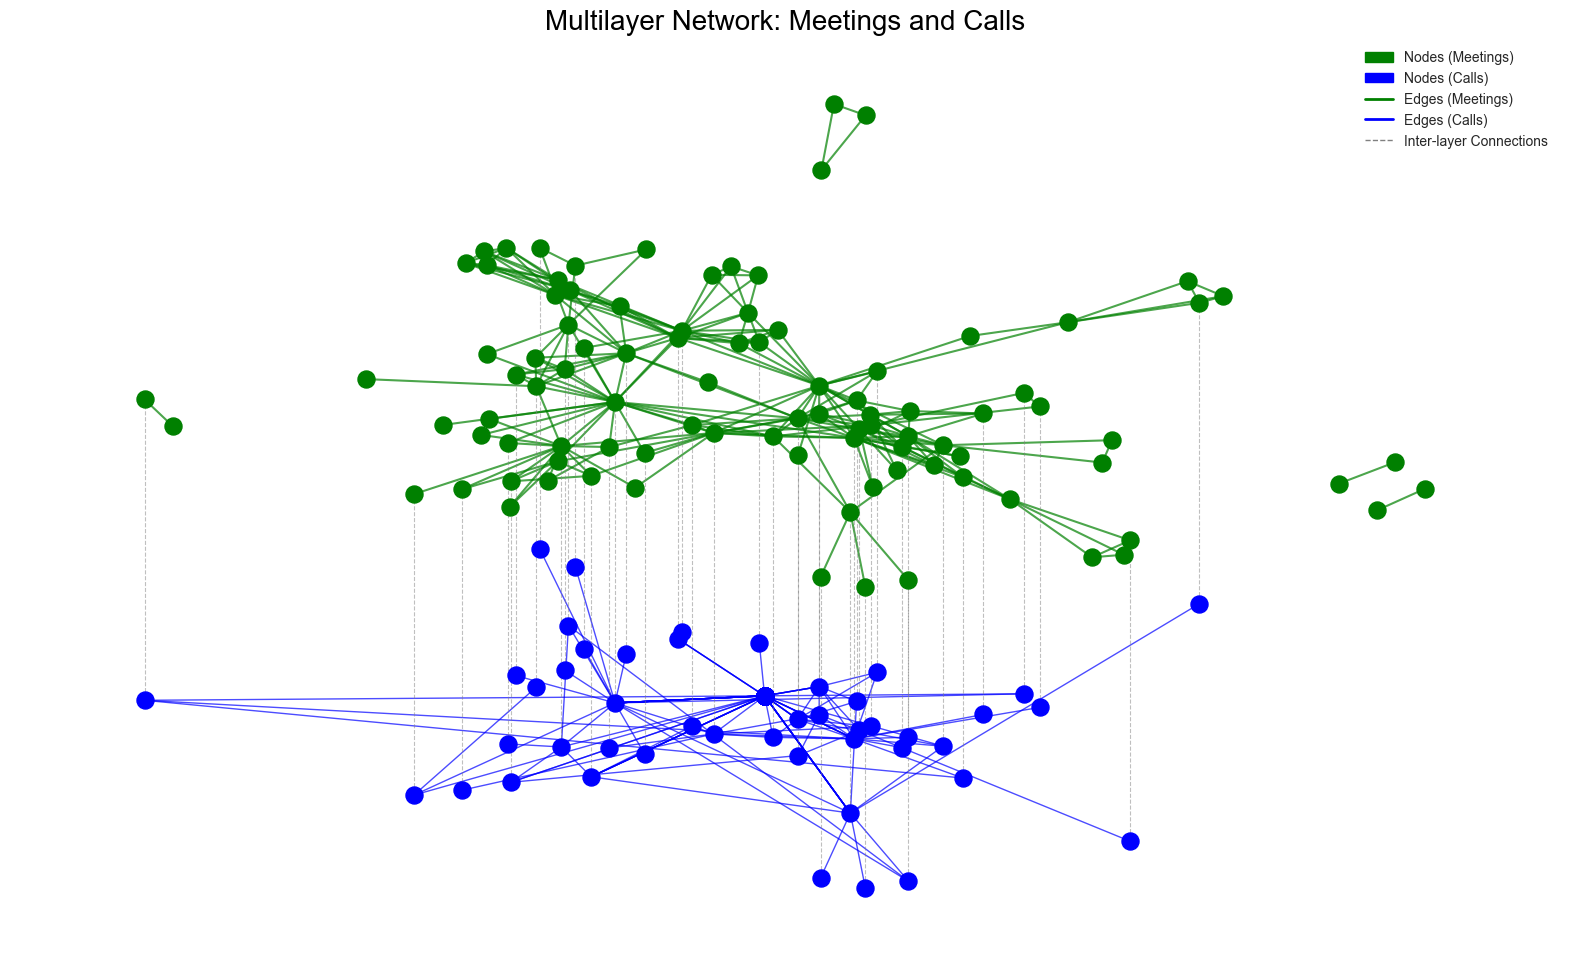

In [18]:
# Plot multilayer graph

def plot_multilayer_clean(G_multi, G_meetings, G_calls):
    
    pos_base = nx.spring_layout(G_meetings, seed=42, iterations=150, k=0.6)
    pos = {}
    layer_y_offset = {0: 1, 1: 0} # Set Y coordinates for each layer

    for node, layer in G_multi.nodes():
        if node not in pos_base:
            pos_base[node] = (0, 0)
        pos[(node, layer)] = (pos_base[node][0], pos_base[node][1] + layer_y_offset[layer])

    # Separate elements for drawing
    nodes_meetings = [(n, l) for n, l in G_multi.nodes() if l == 0]
    nodes_calls = [(n, l) for n, l in G_multi.nodes() if l == 1]
    
    edges_meetings = [(u, v) for u, v, d in G_multi.edges(data=True) if d.get('layer') == 'meetings']
    edges_calls = [(u, v) for u, v, d in G_multi.edges(data=True) if d.get('layer') == 'calls']
    edges_interlayer = [(u, v) for u, v, d in G_multi.edges(data=True) if d.get('layer') == 'interlayer']

    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 12))

    # Draw edges
    nx.draw_networkx_edges(G_multi, pos, edgelist=edges_meetings, edge_color='green', alpha=0.7, width=1.5, ax=ax)
    nx.draw_networkx_edges(G_multi, pos, edgelist=edges_calls, edge_color='blue', alpha=0.7, width=1.0, ax=ax)
    nx.draw_networkx_edges(G_multi, pos, edgelist=edges_interlayer, edge_color='gray', alpha=0.5, width=0.8, style='dashed', ax=ax)

    # Draw nodes
    nx.draw_networkx_nodes(G_multi, pos, nodelist=nodes_meetings, node_color='green', node_size=150, ax=ax)
    nx.draw_networkx_nodes(G_multi, pos, nodelist=nodes_calls, node_color='blue', node_size=150, ax=ax)
    

    # Set Legend
    ax.set_title('Multilayer Network: Meetings and Calls', fontsize=20, color='black')
    ax.axis('off')

    # Create legend
    legend_patches = [
        mpatches.Patch(color='green', label='Nodes (Meetings)'),
        mpatches.Patch(color='blue', label='Nodes (Calls)'),
        plt.Line2D([0], [0], color='green', lw=2, label='Edges (Meetings)'),
        plt.Line2D([0], [0], color='blue', lw=2, label='Edges (Calls)'),
        plt.Line2D([0], [0], color='gray', lw=1, linestyle='--', label='Inter-layer Connections')
    ]
    ax.legend(handles=legend_patches, loc='upper right')
    
    plt.show()


plot_multilayer_clean(G_multi, G_meetings, G_calls)

### Graph analysis

In [19]:
# Find the nodes in common between the two graphs
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())
common_nodes = nodes_meetings & nodes_calls # Intersection

print(f"Nodes in common between Meetings and Phone Calls networks: {len(common_nodes)}")
print("Common nodes:", sorted(common_nodes))

Nodes in common between Meetings and Phone Calls networks: 46
Common nodes: [11, 12, 14, 18, 19, 21, 22, 23, 25, 27, 29, 31, 32, 33, 34, 36, 40, 43, 45, 47, 48, 49, 50, 51, 52, 54, 56, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 75, 77, 80, 95, 96, 97, 98, 99, 100]


In [20]:
# Function to print graph statistics. Statistics include:
# - Number of nodes, edges, and connected components
# - Max and average node degree
# - Max and average edge weight
# - Max shortest path length ("diameter") of largest connected component
# - Average shortest path length of largest connected component
# - Average clustering coefficient
# - Transitivity
def print_graph_stats(G, name="Graph"):
    print(f"--- {name} ---")
    
    # Basic info (number of nodes, edges and components)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Connected components: {num_components}")

    # Node degrees
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    avg_degree = np.mean(list(degrees.values()))
    print(f"Max node degree: {max_degree}")
    print(f"Average node degree: {avg_degree:.4f}")

    # Edge weights
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    avg_weight = np.mean(edge_weights)
    print(f"Max edge weight: {max_weight}")
    print(f"Average edge weight: {avg_weight:.4f}")

    # Shortest path stats
    if nx.is_connected(G):  # Our graphs are disconnected, so this piece is always skipped
        diameter = nx.diameter(G)
        avg_shortest_path = nx.average_shortest_path_length(G)
    else:                   # Work on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        diameter = nx.diameter(G_sub)
        avg_shortest_path = nx.average_shortest_path_length(G_sub)
    print(f"Max shortest path length (diameter): {diameter}")
    print(f"Average shortest path length: {avg_shortest_path:.4f}")

    # Clustering coefficient
    # C(v) = (number of links between neighbors of v) / (maximum possible number of links between them)
    clustering_coeffs = nx.clustering(G)
    avg_clustering = np.mean(list(clustering_coeffs.values()))
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

    # Transitivity
    # Transitivity = (3 × number of triangles) / (number of connected triplets)
    transitivity = nx.transitivity(G)
    print(f"Transitivity: {transitivity:.4f}")
    
    print()  # Blank line for readability

In [21]:
print_graph_stats(G_meetings, name="Meetings Network")
print_graph_stats(G_calls, name="Phone Calls Network")
# print_graph_stats(G_aggregated, name="Aggregated Network")  # Note: there are 47 nodes *in common* between the two networks
# print_graph_stats(G_multi, name="Multilayer Network")

--- Meetings Network ---
Nodes: 95
Edges: 248
Connected components: 5
Max node degree: 23
Average node degree: 5.2211
Max edge weight: 11
Average edge weight: 1.8347
Max shortest path length (diameter): 6
Average shortest path length: 3.1070
Average clustering coefficient: 0.6688
Transitivity: 0.4085

--- Phone Calls Network ---
Nodes: 94
Edges: 120
Connected components: 4
Max node degree: 25
Average node degree: 2.5532
Max edge weight: 15
Average edge weight: 2.3000
Max shortest path length (diameter): 7
Average shortest path length: 3.3325
Average clustering coefficient: 0.1180
Transitivity: 0.0838



In [22]:
# Function to print top X heaviest edges
def print_top_weight_edges(G, top_x=10):
    # Get all edges with weights
    edges_with_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if 'weight' in d]
    
    # Sort by weight descending
    top_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)[:top_x]
    
    print(f"Top {top_x} heaviest edges (u, v, weight):")
    for u, v, w in top_edges:
        print(f"{u} -- {v} (weight: {w})")

# Function to print top X nodes by degree
def print_top_degree_nodes(G, top_x=10):
    # Compute degrees
    degrees = G.degree()
    
    # Sort by degree descending
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:top_x]
    
    print(f"Top {top_x} nodes by degree (node, degree):")
    for node, deg in top_nodes:
        print(f"{node} (degree: {deg})")

In [23]:
print("Meetings Network:")
print_top_degree_nodes(G_meetings, top_x=10)
print_top_weight_edges(G_meetings, top_x=10)

print("Phone Calls Network:")
print_top_degree_nodes(G_calls, top_x=10)
print_top_weight_edges(G_calls, top_x=10)

# print("Aggregated Network:")
# print_top_degree_nodes(G_aggregated, top_x=10)
# print_top_weight_edges(G_aggregated, top_x=10)

# print("Multilayer Network:")
# print_top_degree_nodes(G_multi, top_x=10)
# print_top_weight_edges(G_multi, top_x=10)

Meetings Network:
Top 10 nodes by degree (node, degree):
18 (degree: 23)
68 (degree: 21)
47 (degree: 18)
12 (degree: 16)
22 (degree: 15)
27 (degree: 14)
25 (degree: 13)
29 (degree: 13)
11 (degree: 12)
45 (degree: 12)
Top 10 heaviest edges (u, v, weight):
22 -- 76 (weight: 11)
11 -- 12 (weight: 10)
47 -- 50 (weight: 10)
47 -- 45 (weight: 9)
47 -- 48 (weight: 8)
89 -- 93 (weight: 8)
68 -- 89 (weight: 7)
27 -- 47 (weight: 7)
70 -- 89 (weight: 7)
18 -- 22 (weight: 6)
Phone Calls Network:
Top 10 nodes by degree (node, degree):
18 (degree: 25)
47 (degree: 19)
61 (degree: 16)
27 (degree: 11)
68 (degree: 10)
29 (degree: 9)
75 (degree: 8)
22 (degree: 6)
45 (degree: 6)
54 (degree: 5)
Top 10 heaviest edges (u, v, weight):
18 -- 29 (weight: 15)
18 -- 19 (weight: 11)
61 -- 66 (weight: 10)
47 -- 45 (weight: 7)
18 -- 33 (weight: 6)
29 -- 43 (weight: 6)
61 -- 128 (weight: 6)
43 -- 47 (weight: 6)
18 -- 22 (weight: 5)
18 -- 100 (weight: 5)


### Further analysis

#### Centrality Metrics

In [25]:
def degree_centrality(G):   # degree divided by (n-1), where n is the number of nodes
    return nx.degree_centrality(G)

def weighted_degree_centrality(G):  # same as degree centrality, but considers edge weights
    n = len(G)
    return {node: sum(d['weight'] for _, _, d in G.edges(node, data=True)) / (n-1) for node in G.nodes()}

def betweenness_centrality(G, weight=None):     # Importance is defined as the number of shortest paths that pass through a node
    return nx.betweenness_centrality(G, weight=weight)

def katz_centrality(G, alpha=0.1, beta=1.0):    # Importance is defined based on the importance of neighboring nodes
    try:
        return nx.katz_centrality_numpy(G, alpha=alpha, beta=beta, weight='weight')
    except nx.NetworkXException as e:
        print("Katz centrality error:", e)
        return {}

def collective_influence(G, radius=2):          # Importance is defined based on the influence of neighboring nodes within a certain radius
    CI = {}
    for node in G.nodes():
        ki = G.degree(node)
        if ki <= 1:
            CI[node] = 0
            continue
        ball = nx.ego_graph(G, node, radius=radius, center=False)
        boundary = set(ball.nodes())
        sigma = sum(G.degree(n) - 1 for n in boundary)
        CI[node] = (ki - 1) * sigma
    return CI

def pagerank(G, alpha=0.85, weight='weight'):   # Importance is defined based on the probability of random walks to cross that node
    return nx.pagerank(G, alpha=alpha, weight=weight)

In [26]:
arr_deg_meetings = degree_centrality(G_meetings)
arr_wdeg_meetings = weighted_degree_centrality(G_meetings)
arr_btw_meetings = betweenness_centrality(G_meetings, weight='weight')
arr_katz_meetings = katz_centrality(G_meetings)
arr_ci_meetings = collective_influence(G_meetings, radius=2)
arr_pr_meetings = pagerank(G_meetings)

arr_deg_calls = degree_centrality(G_calls)
arr_wdeg_calls = weighted_degree_centrality(G_calls)
arr_btw_calls = betweenness_centrality(G_calls, weight='weight')
arr_katz_calls = katz_centrality(G_calls)
arr_ci_calls = collective_influence(G_calls, radius=2)
arr_pr_calls = pagerank(G_calls)

# arr_deg_aggregated = degree_centrality(G_aggregated)
# arr_wdeg_aggregated = weighted_degree_centrality(G_aggregated)
# arr_btw_aggregated = betweenness_centrality(G_aggregated, weight='weight')
# arr_katz_aggregated = katz_centrality(G_aggregated)
# arr_ci_aggregated = collective_influence(G_aggregated, radius=2)
# arr_pr_aggregated = pagerank(G_aggregated)

# arr_deg_multilayer = degree_centrality(G_multi)
# arr_wdeg_multilayer = weighted_degree_centrality(G_multi)
# arr_btw_multilayer = betweenness_centrality(G_multi, weight='weight')
# arr_katz_multilayer = katz_centrality(G_multi)
# arr_ci_multilayer = collective_influence(G_multi, radius=2)
# arr_pr_multilayer = pagerank(G_multi)

In [27]:
# DEBUG - Print all measures
print("Degree Centrality (Meetings):", arr_deg_meetings)
print("Weighted Degree Centrality (Meetings):", arr_wdeg_meetings)  #weighted
print("Betweenness Centrality (Meetings):", arr_btw_meetings)       #weighted
print("Katz Centrality (Meetings):", arr_katz_meetings)
# print("Collective Influence (Meetings):", arr_ci_meetings)
# print("PageRank (Meetings):", arr_pr_meetings)                    #weighted
print("")
print("Degree Centrality (Calls):", arr_deg_calls)
print("Weighted Degree Centrality (Calls):", arr_wdeg_calls)
print("Betweenness Centrality (Calls):", arr_btw_calls)             #weighted
print("Katz Centrality (Calls):", arr_katz_calls)                   #weighted
# print("Collective Influence (Calls):", arr_ci_calls)
# print("PageRank (Calls):", arr_pr_calls)                          #weighted  

Degree Centrality (Meetings): {0: 0.02127659574468085, 1: 0.02127659574468085, 2: 0.02127659574468085, 3: 0.0851063829787234, 4: 0.06382978723404255, 5: 0.10638297872340426, 6: 0.10638297872340426, 7: 0.06382978723404255, 8: 0.06382978723404255, 9: 0.06382978723404255, 11: 0.1276595744680851, 12: 0.1702127659574468, 25: 0.13829787234042554, 28: 0.05319148936170213, 10: 0.05319148936170213, 13: 0.06382978723404255, 14: 0.06382978723404255, 68: 0.22340425531914893, 18: 0.24468085106382978, 85: 0.0851063829787234, 21: 0.02127659574468085, 84: 0.0425531914893617, 86: 0.0425531914893617, 87: 0.0425531914893617, 16: 0.010638297872340425, 17: 0.010638297872340425, 19: 0.09574468085106383, 20: 0.02127659574468085, 22: 0.1595744680851064, 23: 0.0851063829787234, 27: 0.14893617021276595, 29: 0.13829787234042554, 31: 0.02127659574468085, 34: 0.06382978723404255, 35: 0.05319148936170213, 43: 0.0851063829787234, 47: 0.19148936170212766, 59: 0.02127659574468085, 60: 0.02127659574468085, 63: 0.042553

In [28]:
# Print top X nodes based on a centrality measure (dicts of (node:value) sorted by value)
def print_top_centrality(arr, top_x=10):
    sorted_nodes = sorted(arr.items(), key=lambda x: x[1], reverse=True)[:top_x]
    for node, value in sorted_nodes:
        # Print node and its value (centrality measure), then information about the node from the role dataset (family and rank, role)
        print(f"{node}: {value:.4f} - Family: {role_info[node]['Family'] if node in role_info else 'N/A'}, "
              f"Rank: {role_info[node]['Rank'] if node in role_info else 'N/A'}, "
              f"Role: {role_info[node]['Role'] if node in role_info else 'N/A'}")

In [29]:
print("Top 10 nodes by Weighted Degree Centrality (Meetings):")
print_top_centrality(arr_wdeg_meetings, top_x=10)
print("Top 10 nodes by Weighted Degree Centrality (Calls):")
print_top_centrality(arr_wdeg_calls, top_x=10)

print("\nTop 10 nodes by Betweenness Centrality (Meetings):")
print_top_centrality(arr_btw_meetings, top_x=10)
print("Top 10 nodes by Betweenness Centrality (Calls):")
print_top_centrality(arr_btw_calls, top_x=10)

print("\nTop 10 nodes by Katz Centrality (Meetings):")
print_top_centrality(arr_katz_meetings, top_x=10)
print("Top 10 nodes by Katz Centrality (Calls):")
print_top_centrality(arr_katz_calls, top_x=10)

Top 10 nodes by Weighted Degree Centrality (Meetings):
47: 0.6702 - Family: Batanesi, Rank: deputy boss, Role: None
89: 0.4894 - Family: Batanesi, Rank: member, Role: None
27: 0.4681 - Family: Batanesi, Rank: executive, Role: None
68: 0.4468 - Family: Batanesi, Rank: executive, Role: None
18: 0.3936 - Family: Mistretta, Rank: executive, Role: None
22: 0.3936 - Family: None, Rank: None, Role: pharmacist-member
45: 0.3936 - Family: Batanesi, Rank: member, Role: None
12: 0.3723 - Family: Mistretta, Rank: member, Role: None
51: 0.3404 - Family: Batanesi, Rank: member, Role: None
48: 0.3298 - Family: Batanesi, Rank: member, Role: None
Top 10 nodes by Weighted Degree Centrality (Calls):
18: 0.7634 - Family: Mistretta, Rank: executive, Role: None
47: 0.5914 - Family: Batanesi, Rank: deputy boss, Role: None
61: 0.4946 - Family: Mistretta, Rank: executive, Role: None
29: 0.3441 - Family: None, Rank: None, Role: enterpreneur
27: 0.2151 - Family: Batanesi, Rank: executive, Role: None
68: 0.2151 -

In [30]:
# Prints centrality as a table with node, value, and role

def get_role_description(node): #Utility to get 'role' as either family&rank or role (or 'unknown' if not available)
    info = role_info[node]
    if info.get('Family') and info.get('Rank'):
        return f"{info['Family']} {info['Rank']}"
    elif info.get('Role'):
        return info['Role']
    else:
        return "unknown"

def print_top_centrality_table(arr_meetings, arr_calls, top_x=5):
    """Prints top X nodes for each measure, with a layout of: Meetings - Calls, each subdivided into: node, value, role."""
    sorted_meetings = sorted(arr_meetings.items(), key=lambda x: x[1], reverse=True)[:top_x]
    sorted_calls = sorted(arr_calls.items(), key=lambda x: x[1], reverse=True)[:top_x]
    
    print(f"{'Position':<10} {'Meetings':<30} {'Calls':<30}")
    print(f"{'':<10} {'Node':<10} {'Value':<10} {'Role':<20} {'Node':<10} {'Value':<10} {'Role':<20}")
    
    for i in range(top_x):
        node_meetings, value_meetings = sorted_meetings[i] if i < len(sorted_meetings) else (None, None)
        node_calls, value_calls = sorted_calls[i] if i < len(sorted_calls) else (None, None)
        
        role_meetings = get_role_description(node_meetings) if node_meetings is not None else "N/A"
        role_calls = get_role_description(node_calls) if node_calls is not None else "N/A"
        
        print(f"{i+1:<10} {node_meetings:<10} {value_meetings:<10.4f} {role_meetings:<20} {node_calls:<10} {value_calls:<10.4f} {role_calls:<20}")

In [31]:
print("Top 5 nodes by Weighted Degree Centrality:")
print_top_centrality_table(arr_wdeg_meetings, arr_wdeg_calls, top_x=5)
print("\nTop 5 nodes by Betweenness Centrality:")
print_top_centrality_table(arr_btw_meetings, arr_btw_calls, top_x=5)
print("\nTop 5 nodes by Katz Centrality:")
print_top_centrality_table(arr_katz_meetings, arr_katz_calls, top_x=5)

Top 5 nodes by Weighted Degree Centrality:
Position   Meetings                       Calls                         
           Node       Value      Role                 Node       Value      Role                
1          47         0.6702     Batanesi deputy boss 18         0.7634     Mistretta executive 
2          89         0.4894     Batanesi member      47         0.5914     Batanesi deputy boss
3          27         0.4681     Batanesi executive   61         0.4946     Mistretta executive 
4          68         0.4468     Batanesi executive   29         0.3441     enterpreneur        
5          18         0.3936     Mistretta executive  27         0.2151     Batanesi executive  

Top 5 nodes by Betweenness Centrality:
Position   Meetings                       Calls                         
           Node       Value      Role                 Node       Value      Role                
1          18         0.3332     Mistretta executive  18         0.4181     Mistretta execut

Note: node 23 is an 'executive' but his family is unknown.

Nodes 99, 112 and 113 are unaffiliated individuals with an 'external partnership'.

#### Groups and Clustering metrics

In [32]:
from networkx.algorithms.community import greedy_modularity_communities
from matplotlib import cm
from matplotlib.patches import Patch
import community as community_louvain
import igraph as ig     #pip install
import leidenalg        #pip install

# Function to compute greedy modularity communities
def compute_greedy_communities(G):
    return list(greedy_modularity_communities(G))

# Function to compute communities using the Louvain method
def compute_louvain_communities(G):
    partition = community_louvain.best_partition(G, weight='weight')
    communities = {}
    for node, com in partition.items():
        if com not in communities:
            communities[com] = []
        communities[com].append(node)
    return list(communities.values())

# Function to compute communities using the Leiden method
def compute_leiden_communities(G):
    # Build edge list with float weights
    edge_list = []
    for u, v, data in G.edges(data=True):
        weight = float(data.get('weight', 1.0))  # Convert to float
        edge_list.append((u, v, weight))

    # Ensure consistent node indexing (igraph uses consecutive integers)
    name_to_index = {name: idx for idx, name in enumerate(G.nodes())}
    indexed_edges = [(name_to_index[u], name_to_index[v], w) for u, v, w in edge_list]
    index_to_name = {idx: name for name, idx in name_to_index.items()}

    # Create iGraph graph
    g_ig = ig.Graph()
    g_ig.add_vertices(len(name_to_index))
    g_ig.add_edges([(u, v) for u, v, _ in indexed_edges])
    g_ig.es['weight'] = [w for _, _, w in indexed_edges]

    # Run Leiden algorithm
    partition = leidenalg.find_partition(
        g_ig,
        leidenalg.ModularityVertexPartition,
        weights=g_ig.es['weight']
    )

    # Translate communities back to original node names
    communities = [[index_to_name[idx] for idx in community] for community in partition]

    return communities

In [33]:
# Function to draw a graph with communities colored differently
def draw_communities(G, communities, title='Community Graph'):
    color_map = {}
    cmap = plt.colormaps.get_cmap('tab20')  # Safe for up to 20 distinct groups

    legend_patches = []
    for i, community in enumerate(communities):
        color = cmap(i / max(1, len(communities) - 1))  # Normalize index to 0–1
        for node in community:
            color_map[node] = color
        legend_patches.append(Patch(color=color, label=f"Community {i+1}"))

    node_colors = [color_map.get(node, 'gray') for node in G.nodes()]
    pos = nx.spring_layout(G, k=0.25, seed=42)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.85)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.legend(handles=legend_patches, loc='best', fontsize=8)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Meetings Network - Greedy Communities:
  Community 1: frozenset({68, 69, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97, 36, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55})
  Community 2: frozenset({64, 65, 71, 72, 75, 76, 77, 78, 18, 21, 22, 26, 27, 29, 30, 31, 98, 99, 43, 59, 60, 63})
  Community 3: frozenset({3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 84, 85, 86, 87, 25, 28})
  Community 4: frozenset({32, 33, 34, 35, 100, 19, 20, 23, 88, 24})
  Community 5: frozenset({80, 81, 82, 83, 79})
  Community 6: frozenset({40, 41, 42, 39})
  Community 7: frozenset({66, 67, 61, 62})
  Community 8: frozenset({0, 1, 2})
  Community 9: frozenset({16, 17})
  Community 10: frozenset({56, 57})
  Community 11: frozenset({73, 74})


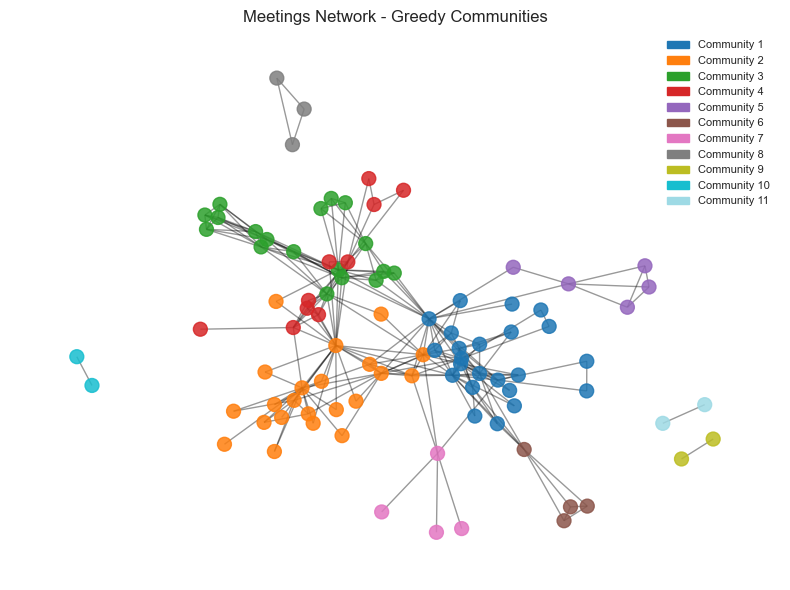

Phone Calls Network - Greedy Communities:
  Community 1: frozenset({66, 132, 71, 140, 18, 19, 146, 21, 22, 25, 153, 31, 32, 33, 34, 100, 102, 103, 104, 108, 109, 110, 111, 52, 124, 127})
  Community 2: frozenset({139, 147, 29, 95, 96, 98, 43, 47, 48, 49, 50, 51, 56, 121, 123, 125, 63})
  Community 3: frozenset({128, 129, 130, 67, 131, 133, 134, 105, 80, 117, 61, 62})
  Community 4: frozenset({97, 36, 70, 136, 138, 148, 119, 27, 126})
  Community 5: frozenset({68, 69, 40, 45, 149, 54, 151, 150, 152})
  Community 6: frozenset({64, 137, 75, 77, 112, 113, 114, 115, 116})
  Community 7: frozenset({144, 145, 11, 12, 143})
  Community 8: frozenset({99, 118, 23})
  Community 9: frozenset({101, 14})
  Community 10: frozenset({106, 107})


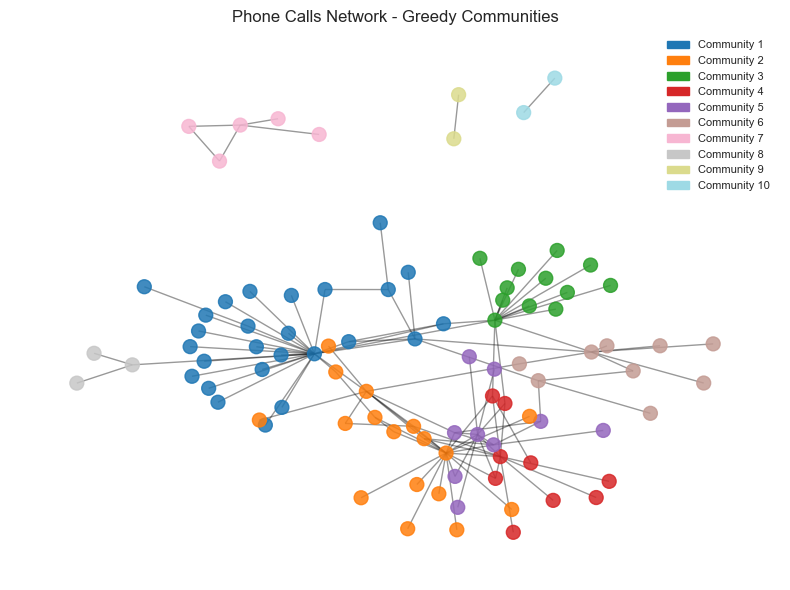

Meetings Network - Louvain Communities:
  Community 1: [0, 1, 2]
  Community 2: [3, 4, 5, 6, 7, 8, 9, 11, 12, 25, 28, 10, 13, 14, 85, 84, 86, 87, 26]
  Community 3: [68, 27, 47, 45, 51, 70, 89, 97, 54, 36, 46, 48, 91, 92, 49, 50, 55, 94, 90, 93, 95, 52, 96, 69]
  Community 4: [18, 21, 22, 29, 31, 43, 59, 60, 63, 64, 65, 71, 76, 30, 72, 75, 77, 78, 98, 99]
  Community 5: [16, 17]
  Community 6: [19, 20, 23, 34, 35, 100, 32, 33, 88, 24]
  Community 7: [61, 62, 66, 67]
  Community 8: [39, 40, 41, 42]
  Community 9: [56, 57]
  Community 10: [79, 83, 80, 81, 82]
  Community 11: [73, 74]


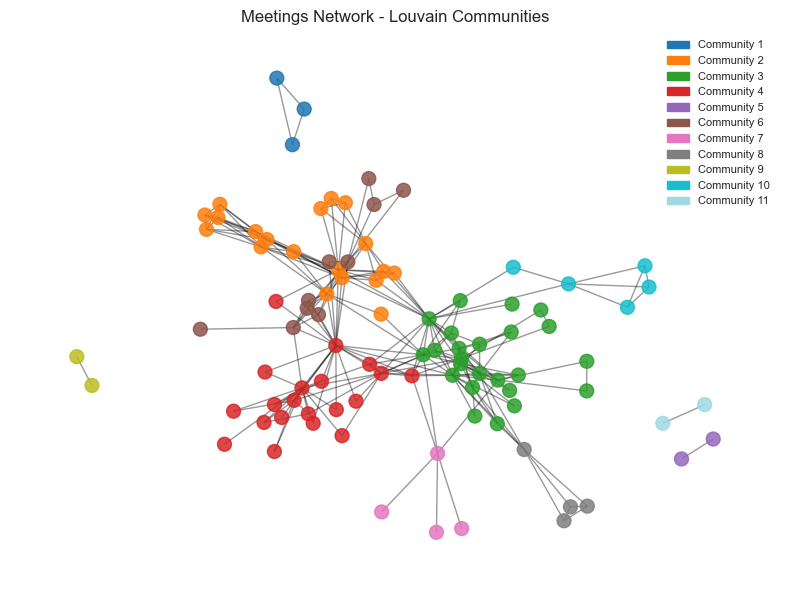

Phone Calls Network - Louvain Communities:
  Community 1: [11, 12, 143, 144, 145]
  Community 2: [14, 101]
  Community 3: [18, 19, 21, 25, 29, 32, 33, 34, 52, 71, 100, 102, 103, 104, 108, 125, 127, 132, 140, 146, 153, 63, 98, 139, 124]
  Community 4: [22, 110, 31, 77, 109, 69, 137, 111]
  Community 5: [61, 66, 36, 148, 62, 67, 80, 105, 117, 128, 129, 130, 131, 133, 134]
  Community 6: [99, 23, 118]
  Community 7: [75, 64, 112, 113, 114, 115, 116]
  Community 8: [27, 43, 47, 51, 68, 70, 97, 119, 126, 136, 138, 54, 40, 45, 48, 49, 50, 56, 95, 96, 121, 123, 147, 151, 149, 150, 152]
  Community 9: [106, 107]


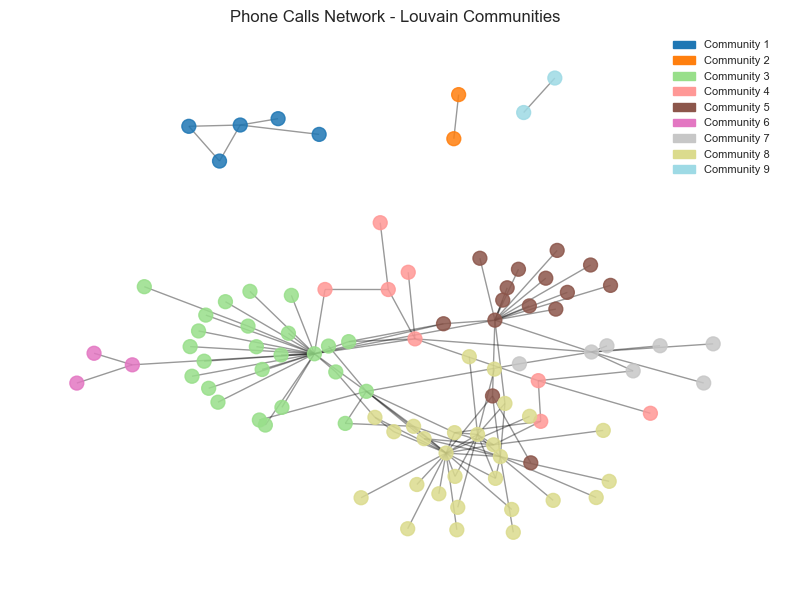

Meetings Network - Leiden Communities:
  Community 1: [18, 21, 19, 20, 22, 23, 31, 34, 35, 59, 60, 63, 65, 71, 76, 100, 32, 33, 88, 30, 72, 75, 77, 78, 98, 99, 24]
  Community 2: [47, 45, 51, 36, 46, 48, 91, 92, 39, 40, 41, 42, 49, 50, 55, 94, 90, 52, 96]
  Community 3: [3, 4, 5, 6, 7, 8, 9, 11, 12, 25, 28, 10, 13, 14, 85, 84, 86, 87, 26]
  Community 4: [68, 27, 29, 43, 64, 70, 89, 97, 54, 93, 95, 69]
  Community 5: [79, 83, 80, 81, 82]
  Community 6: [61, 62, 66, 67]
  Community 7: [0, 1, 2]
  Community 8: [16, 17]
  Community 9: [56, 57]
  Community 10: [73, 74]


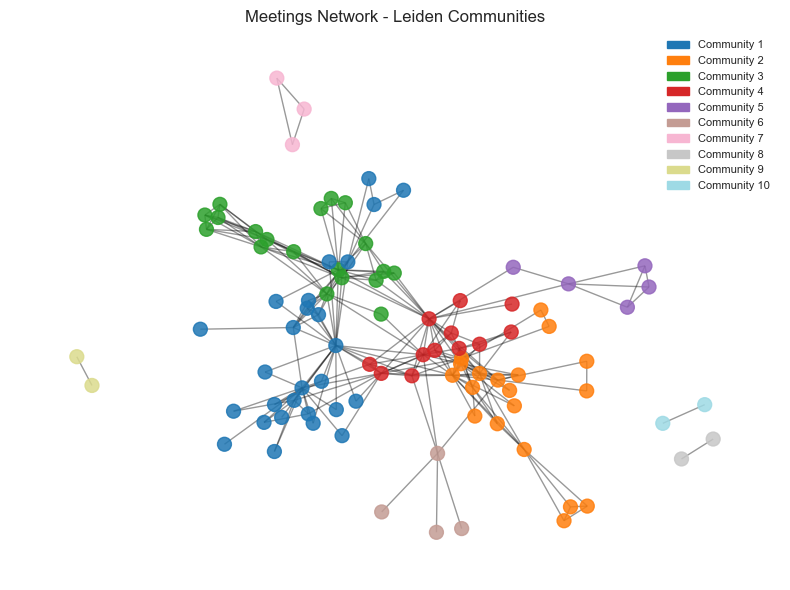

Phone Calls Network - Leiden Communities:
  Community 1: [27, 36, 43, 47, 51, 68, 70, 97, 119, 126, 136, 138, 54, 148, 40, 45, 48, 49, 50, 56, 95, 96, 121, 123, 147, 151, 149, 150, 152]
  Community 2: [18, 19, 21, 25, 29, 32, 33, 34, 52, 71, 100, 102, 103, 104, 108, 125, 127, 132, 140, 146, 153, 63, 98, 139, 124]
  Community 3: [61, 66, 62, 67, 80, 105, 117, 128, 129, 130, 131, 133, 134]
  Community 4: [22, 110, 31, 77, 109, 69, 137, 111]
  Community 5: [75, 64, 112, 113, 114, 115, 116]
  Community 6: [11, 12, 143, 144, 145]
  Community 7: [99, 23, 118]
  Community 8: [14, 101]
  Community 9: [106, 107]


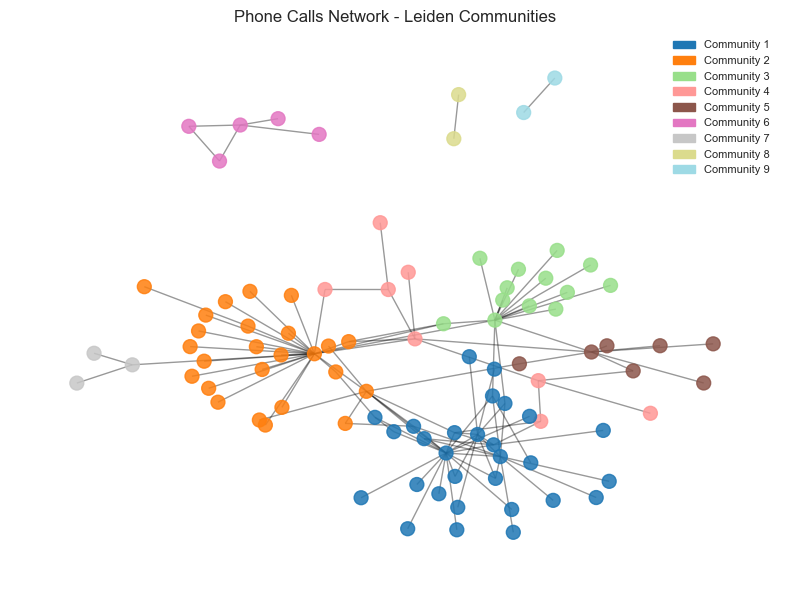

In [34]:
# Plot communities for each graph

graphs = {
    "Meetings Network": G_meetings,
    "Phone Calls Network": G_calls,
    # "Aggregated Network": G_aggregated,
    # "Multilayer Network": G_multi,
}

# Store communities and print / visualize them
communities_per_graph_greedy = {}
communities_per_graph_louvain = {}
communities_per_graph_leiden = {}

for name, G in graphs.items():
    communities_greedy = compute_greedy_communities(G)
    communities_per_graph_greedy[name] = communities_greedy
    communities_louvain = compute_louvain_communities(G)
    communities_per_graph_louvain[name] = communities_louvain
    communities_leiden = compute_leiden_communities(G)
    communities_per_graph_leiden[name] = communities_leiden

for name, communities in communities_per_graph_greedy.items():
    print(f"{name} - Greedy Communities:")
    for i, community in enumerate(communities):
        print(f"  Community {i+1}: {community}")
    draw_communities(graphs[name], communities, title=f"{name} - Greedy Communities")
for name, communities in communities_per_graph_louvain.items():
    print(f"{name} - Louvain Communities:")
    for i, community in enumerate(communities):
        print(f"  Community {i+1}: {community}")
    draw_communities(graphs[name], communities, title=f"{name} - Louvain Communities")
for name, communities in communities_per_graph_leiden.items():
    print(f"{name} - Leiden Communities:")
    for i, community in enumerate(communities):
        print(f"  Community {i+1}: {community}")
    draw_communities(graphs[name], communities, title=f"{name} - Leiden Communities")

In [35]:
from matplotlib.patches import Patch

def build_global_family_color_map(graphs):
    # Define the custom color map manually
    custom_colors = {
        'Barcellona Pozzo Di Gotto': "#e41a1c", # 2
        'Caltagirone': '#035c00',               # 1
        'Mistretta': '#4daf4a',                 # 9, second most nodes
        'Mazzaroti': '#ff7f00',                 # 3
        'Brancaccio': '#984ea3',                # 1
        'San Mauro Castelverde': "#86451f",     # 1
        'Batanesi': '#377eb8',                  # 17, most nodes
        'Tortorici': "#FF00D0",                 # 2
    }

    return custom_colors

family_color_map = build_global_family_color_map([G_meetings, G_calls])

# Function to draw a graph colored by mafia family
def draw_by_family_color(G, title='Graph Colored by Mafia Family', family_color_map=family_color_map, multilayer=False):

    # Determine node colors
    node_colors = []
    for node in G.nodes():
        data = G.nodes[node]
        fam = data.get('Family')
        if fam in family_color_map:
            node_colors.append(family_color_map[fam])
        else:
            node_colors.append('lightgray')

    # Create legend, with only the families that are present in the graph
    legend_patches = []
    for family, color in family_color_map.items():
        if any(data.get('Family') == family for data in G.nodes.values()):
            legend_patches.append(Patch(color=color, label=family))
    # Add a patch for nodes without a family
    legend_patches.append(Patch(color='lightgray', label='No Family'))

    # Draw
    pos = nx.spring_layout(G, k=0.25, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=120, alpha=0.85)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    plt.legend(handles=legend_patches, fontsize=8, loc='best')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


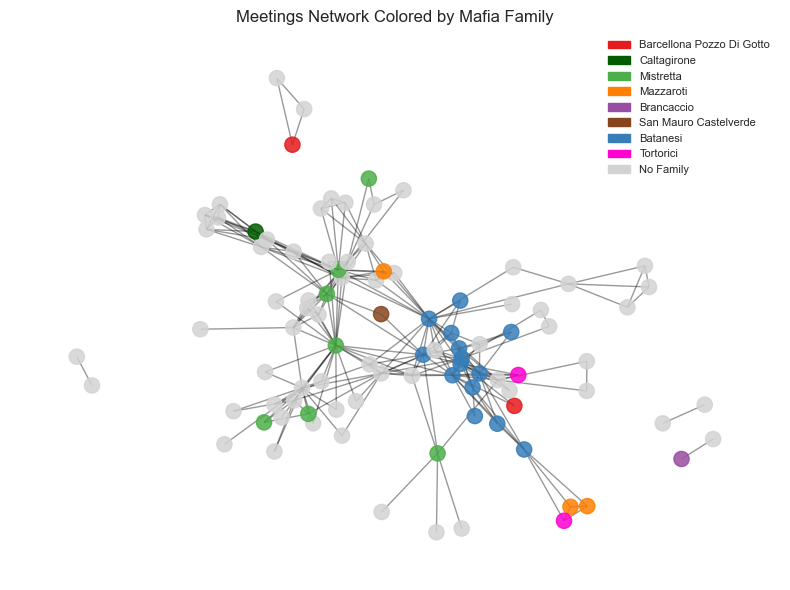

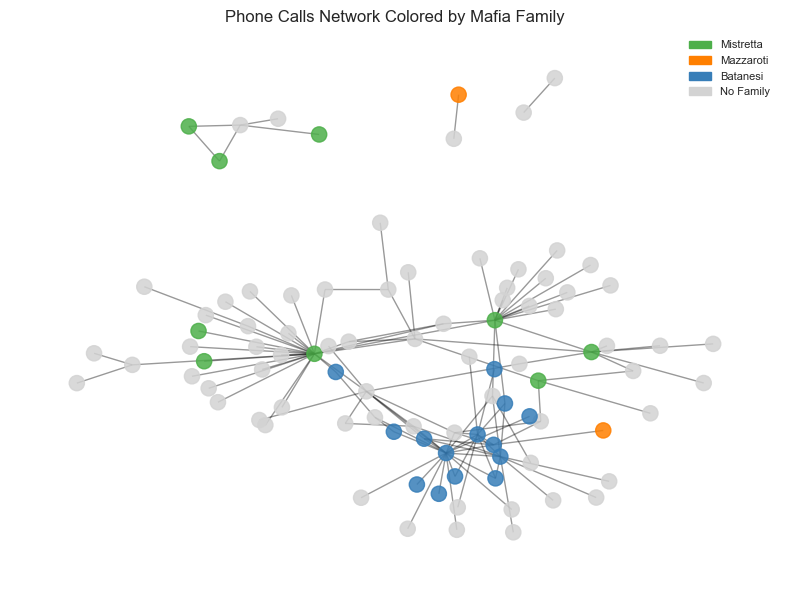

In [36]:
draw_by_family_color(G_meetings, "Meetings Network Colored by Mafia Family")
draw_by_family_color(G_calls, "Phone Calls Network Colored by Mafia Family")
# draw_by_family_color(G_aggregated, "Aggregated Network Colored by Mafia Family")
# draw_by_family_color(G_multi, "Multilayer Network Colored by Mafia Family", multilayer=True)

In [37]:
from collections import Counter, defaultdict

# Compare the clusters found with the real families
def compare_communities_to_families(G, communities):

    # Build mapping from nodes to community index
    node_to_community = {}
    for i, comm in enumerate(communities):
        for node in comm:
            node_to_community[node] = i

    # Extract nodes with known families
    family_members = defaultdict(set)
    for node, data in G.nodes(data=True):
        fam = data.get('Family')
        if fam and str(fam).strip().lower() != 'none':
            family_members[fam].add(node)

    # Compare each family to each community
    for family, members in family_members.items():
        # Count overlaps with each community
        overlap_counts = Counter()
        for node in members:
            if node in node_to_community:
                comm_id = node_to_community[node]
                overlap_counts[comm_id] += 1

        if not overlap_counts:
            print(f"\nFamily '{family}' has no overlapping nodes with any detected community.")
            continue

        # Get best matching community
        best_comm_id, best_overlap = overlap_counts.most_common(1)[0]
        best_community = communities[best_comm_id]
        matched_nodes = sorted(set(best_community) & members)

        print(f" Family: {family}")
        print(f"  Real members {len(members)} node(s): {sorted(members)}")
        print(f"  Best community is n°{best_comm_id+1}: {sorted(set(best_community))}")
        print(f"  Overlap: {len(matched_nodes)} node(s): {matched_nodes}")
    print("")

In [38]:
# Apply comparison function to each graph's communities
for graph_name, G in graphs.items():
    for method, communities in zip(
        ['Greedy', 'Louvain', 'Leiden'],
        [communities_per_graph_greedy[graph_name], communities_per_graph_louvain[graph_name], communities_per_graph_leiden[graph_name]]
    ):
        print(f"\n{graph_name} - {method} Communities:")
        compare_communities_to_families(G, communities)


Meetings Network - Greedy Communities:
 Family: Barcellona Pozzo Di Gotto
  Real members 2 node(s): [2, 55]
  Best community is n°8: [0, 1, 2]
  Overlap: 1 node(s): [2]
 Family: Caltagirone
  Real members 1 node(s): [3]
  Best community is n°3: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 28, 84, 85, 86, 87]
  Overlap: 1 node(s): [3]
 Family: Mistretta
  Real members 7 node(s): [12, 18, 25, 32, 61, 75, 77]
  Best community is n°2: [18, 21, 22, 26, 27, 29, 30, 31, 43, 59, 60, 63, 64, 65, 71, 72, 75, 76, 77, 78, 98, 99]
  Overlap: 3 node(s): [18, 75, 77]
 Family: Mazzaroti
  Real members 3 node(s): [14, 40, 41]
  Best community is n°6: [39, 40, 41, 42]
  Overlap: 2 node(s): [40, 41]
 Family: Batanesi
  Real members 14 node(s): [27, 39, 45, 47, 48, 49, 50, 51, 68, 70, 89, 90, 95, 97]
  Best community is n°1: [36, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 68, 69, 70, 89, 90, 91, 92, 93, 94, 95, 96, 97]
  Overlap: 12 node(s): [45, 47, 48, 49, 50, 51, 68, 70, 89, 90, 95, 97]
 Family: Brancac

#### Further info on family and rank

In [39]:
# Stats on family distribution
def print_family_distribution(G):
    total_nodes = G.number_of_nodes()
    print(f"Total nodes in the graph: {total_nodes}")

    # Collect families from the graph itself
    families = set(
        data.get('Family')
        for _, data in G.nodes(data=True)
        if 'Family' in data and data.get('Family') is not None
    )

    # Separate None/empty from real families
    real_families = {fam for fam in families if fam is not None}
    family_counts = {fam: 0 for fam in real_families}
    count_with_family = 0
    count_no_family = 0

    # Count nodes
    for _, data in G.nodes(data=True):
        fam = data.get('Family')
        if fam is not None:
            family_counts[fam] += 1
            count_with_family += 1
        else:
            count_no_family += 1

    # Print totals
    perc_with_family = (count_with_family / total_nodes) * 100 if total_nodes > 0 else 0
    perc_no_family = (count_no_family / total_nodes) * 100 if total_nodes > 0 else 0
    print(f"Nodes in a family: {count_with_family} ({perc_with_family:.2f}%)")
    print(f"Nodes with no family: {count_no_family} ({perc_no_family:.2f}%)")

    # Print breakdown for each family
    for family, count in sorted(family_counts.items(), key=lambda x: x[0]):  # sort alphabetically
        percentage = (count / total_nodes) * 100 if total_nodes > 0 else 0
        print(f"  {family}: {count} nodes ({percentage:.2f}%)")

print("Family distribution in Meetings Network:")
print_family_distribution(G_meetings)
print("\nFamily distribution in Phone Calls Network:")
print_family_distribution(G_calls)

Family distribution in Meetings Network:
Total nodes in the graph: 95
Nodes in a family: 31 (32.63%)
Nodes with no family: 64 (67.37%)
  Barcellona Pozzo Di Gotto: 2 nodes (2.11%)
  Batanesi: 14 nodes (14.74%)
  Brancaccio: 1 nodes (1.05%)
  Caltagirone: 1 nodes (1.05%)
  Mazzaroti: 3 nodes (3.16%)
  Mistretta: 7 nodes (7.37%)
  San Mauro Castelverde: 1 nodes (1.05%)
  Tortorici: 2 nodes (2.11%)

Family distribution in Phone Calls Network:
Total nodes in the graph: 94
Nodes in a family: 25 (26.60%)
Nodes with no family: 69 (73.40%)
  Batanesi: 14 nodes (14.89%)
  Mazzaroti: 2 nodes (2.13%)
  Mistretta: 9 nodes (9.57%)


In [40]:
# Stats on rank distribution, for each family
def print_family_rank_distribution(G):
    # Collect info from the graph itself
    family_rank_counts = {}
    family_totals = {}

    for _, data in G.nodes(data=True):
        fam = data.get('Family')
        rank = data.get('Rank')
        if fam:
            # Track total nodes per family
            family_totals[fam] = family_totals.get(fam, 0) + 1

            # Count ranks per family
            if fam not in family_rank_counts:
                family_rank_counts[fam] = {}
            if rank:
                family_rank_counts[fam][rank] = family_rank_counts[fam].get(rank, 0) + 1

    # Print info for each family and its ranks
    for family in sorted(family_rank_counts.keys()):
        total_family_nodes = family_totals[family]
        print(f"Family: {family} (total {total_family_nodes} nodes)")
        for rank, count in sorted(family_rank_counts[family].items(), key=lambda x: x[0]):
            percentage = (count / total_family_nodes) * 100 if total_family_nodes > 0 else 0
            print(f"  {rank}: {count} nodes ({percentage:.2f}%)")
        print()  # Blank line for readability


print("Family Rank distribution in Meetings Network:")
print_family_rank_distribution(G_meetings)
print("\nFamily Rank distribution in Phone Calls Network:")
print_family_rank_distribution(G_calls)


Family Rank distribution in Meetings Network:
Family: Barcellona Pozzo Di Gotto (total 2 nodes)
  boss: 1 nodes (50.00%)
  member: 1 nodes (50.00%)

Family: Batanesi (total 14 nodes)
  deputy boss: 1 nodes (7.14%)
  executive: 3 nodes (21.43%)
  member: 10 nodes (71.43%)

Family: Brancaccio (total 1 nodes)
  boss: 1 nodes (100.00%)

Family: Caltagirone (total 1 nodes)
  boss: 1 nodes (100.00%)

Family: Mazzaroti (total 3 nodes)
  boss: 1 nodes (33.33%)
  member: 2 nodes (66.67%)

Family: Mistretta (total 7 nodes)
  executive: 3 nodes (42.86%)
  member: 4 nodes (57.14%)

Family: San Mauro Castelverde (total 1 nodes)
  member: 1 nodes (100.00%)

Family: Tortorici (total 2 nodes)
  boss: 2 nodes (100.00%)


Family Rank distribution in Phone Calls Network:
Family: Batanesi (total 14 nodes)
  co-founder: 1 nodes (7.14%)
  deputy boss: 1 nodes (7.14%)
  executive: 2 nodes (14.29%)
  member: 10 nodes (71.43%)

Family: Mazzaroti (total 2 nodes)
  boss: 1 nodes (50.00%)
  member: 1 nodes (50.00

#### Clustering coefficient and Transitivity

Note: this data has already been mentioned in the general information. This is just a repeat, mostly to get the graph.

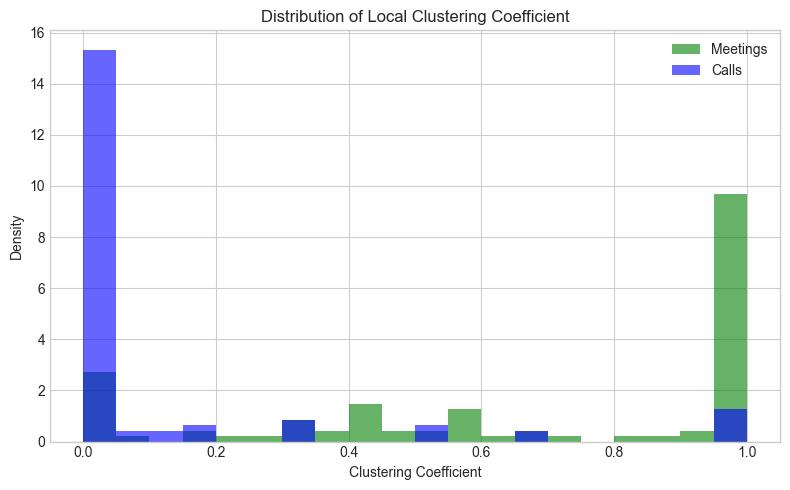

In [41]:
def plot_clustering_distribution(G1, G2, name1='Meetings', name2='Calls'):
    c1 = list(nx.clustering(G1).values())
    c2 = list(nx.clustering(G2).values())

    plt.figure(figsize=(8, 5))
    plt.hist(c1, bins=20, alpha=0.6, label=name1, density=True, color='green')
    plt.hist(c2, bins=20, alpha=0.6, label=name2, density=True, color='blue')
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Density")
    plt.title("Distribution of Local Clustering Coefficient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_clustering_distribution(G_meetings, G_calls, name1='Meetings', name2='Calls')

Note: If the Meetings network has a clustering distribution skewed right (towards 1), it suggests that people who meet tend to form tight groups (trust-based, clique-like substructures).
If the Calls network skews left (towards 0), it may suggest that Phone communications are more spread-out, one-to-many, or hierarchical, a.k.a.generlally less tight. 

In [42]:
# Average clustering coefficient and transitivity. This is a repeated stat.
avg_c_meetings = nx.average_clustering(G_meetings)
avg_c_calls = nx.average_clustering(G_calls)
trans_meetings = nx.transitivity(G_meetings)
trans_calls = nx.transitivity(G_calls)

print(f"Average clustering coefficient:\n  Meetings: {avg_c_meetings:.4f}\n  Calls:    {avg_c_calls:.4f}")
print(f"Transitivity:\n  Meetings: {trans_meetings:.4f}\n  Calls:    {trans_calls:.4f}")

Average clustering coefficient:
  Meetings: 0.6688
  Calls:    0.1180
Transitivity:
  Meetings: 0.4085
  Calls:    0.0838


#### Assortativity and Homophily

In [43]:
# Assortativity Coefficient
def calculate_assortativity(G):
    """Calculate the assortativity coefficient of a graph."""
    weighted_degree_assortativity = nx.degree_assortativity_coefficient(G, weight='weight')
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    return weighted_degree_assortativity, degree_assortativity

weighted_assortativity_meetings, assortativity_meetings = calculate_assortativity(G_meetings)
weighted_assortativity_calls, assortativity_calls = calculate_assortativity(G_calls)
print(f"Degree Assortativity Coefficient:\n  Meetings: {weighted_assortativity_meetings:.4f} (unweighted: {assortativity_meetings:.4f})\n  Calls:    {weighted_assortativity_calls:.4f} (unweighted: {assortativity_calls:.4f})")

Degree Assortativity Coefficient:
  Meetings: 0.0902 (unweighted: -0.0557)
  Calls:    -0.3977 (unweighted: -0.4574)


In [45]:
def compute_family_homophily_by_rank(G):
    """
    For all nodes with a real Family:
        - computes general homophily (fraction of neighbors with the same family)
        - also computes it per rank ('boss', 'member', etc.)
    Edges to nodes without a family are counted in the denominator. Non-family to non-family edges are ignored.
    """
    import pandas as pd  # if not already imported

    # === Extract nodes with a family assigned ===
    nodes_with_family = [
        n for n, d in G.nodes(data=True)
        if 'Family' in d and pd.notna(d['Family']) and d['Family'] is not None
    ]

    scores_all = []  # for general homophily
    rank_scores = {}  # to collect scores per rank

    for node in nodes_with_family:
        d = G.nodes[node]
        node_family = d['Family']
        node_rank = d.get('Rank', None)

        total = 0
        same = 0

        for nbr in G.neighbors(node):
            nbr_family = G.nodes[nbr].get('Family', None)
            if pd.notna(nbr_family) and nbr_family is not None:
                total += 1
                if nbr_family == node_family:
                    same += 1
            elif 'Family' in G.nodes[nbr]:  # family field is present but nan or None
                total += 1

        if total > 0:
            ratio = same / total
            scores_all.append(ratio)

            if node_rank:
                if node_rank not in rank_scores:
                    rank_scores[node_rank] = []
                rank_scores[node_rank].append(ratio)

    # Sort rank_scores by rank: member, executive, deputy boss, boss
    rank_order = ['member', 'executive', 'co-founder', 'deputy boss', 'boss']
    rank_scores = {rank: rank_scores[rank] for rank in rank_order if rank in rank_scores}

    # === Results ===
    general_homophily = sum(scores_all) / len(scores_all) if scores_all else None

    homophily_by_rank = {
        rank: sum(scores) / len(scores)
        for rank, scores in rank_scores.items()
        if scores
    }

    return general_homophily, homophily_by_rank

homophily_by_rank_meetings = compute_family_homophily_by_rank(G_meetings)
homophily_by_rank_calls = compute_family_homophily_by_rank(G_calls)

print("Family Homophily by Rank (Meetings):")
print(f"  General family homophily: {homophily_by_rank_meetings[0]:.4f}")
print("  Homophily by Rank:")
for rank, score in homophily_by_rank_meetings[1].items():
    print(f"    Rank - {rank}: {score:.4f}")
print("\nFamily Homophily by Rank (Calls):")
print(f"  General family homophily: {homophily_by_rank_calls[0]:.4f}")
print("  Homophily by Rank:")
for rank, score in homophily_by_rank_calls[1].items():
    print(f"    Rank - {rank}: {score:.4f}")

Family Homophily by Rank (Meetings):
  General family homophily: 0.3749
  Homophily by Rank:
    Rank - member: 0.5225
    Rank - executive: 0.2771
    Rank - deputy boss: 0.5556
    Rank - boss: 0.0000

Family Homophily by Rank (Calls):
  General family homophily: 0.5387
  Homophily by Rank:
    Rank - member: 0.5613
    Rank - executive: 0.4799
    Rank - co-founder: 1.0000
    Rank - deputy boss: 0.5263
    Rank - boss: 0.0000


In [64]:
# DEBUG: list interactions of important nodes

# === bosses ===
boss_nodes = [
    n for n, d in G_meetings.nodes(data=True) 
    if isinstance(d.get('Rank'), str) and d['Rank'].strip().lower() == 'boss'
]
for n in boss_nodes:
    fam = G_meetings.nodes[n].get('Family')
    nbr_info = [(v, G_meetings.nodes[v].get('Family')) for v in G_meetings.neighbors(n)]
    print(f"Boss {n} ('{fam}') -> neighbors: {nbr_info} (meetings)")

boss_nodes = [
    n for n, d in G_calls.nodes(data=True) 
    if isinstance(d.get('Rank'), str) and d['Rank'].strip().lower() == 'boss'
]
for n in boss_nodes:
    fam = G_calls.nodes[n].get('Family')
    nbr_info = [(v, G_calls.nodes[v].get('Family')) for v in G_calls.neighbors(n)]
    print(f"Boss {n} ('{fam}') -> neighbors: {nbr_info} (calls)")

# === co-founder ===
co_founder_node = [
    n for n, d in G_calls.nodes(data=True) 
    if isinstance(d.get('Rank'), str) and d['Rank'].strip().lower() == 'co-founder'
]
if co_founder_node:
    n = co_founder_node[0]  # only one
    fam = G_calls.nodes[n].get('Family')
    nbr_info = [(v, G_calls.nodes[v].get('Family')) for v in G_calls.neighbors(n)]
    print(f"Co-founder {n} ('{fam}') -> neighbors: {nbr_info} (calls)")

# === deputy Boss ===
deputy_boss_node = [
    n for n, d in G_meetings.nodes(data=True) 
    if isinstance(d.get('Rank'), str) and d['Rank'].strip().lower() == 'deputy boss'
]
if deputy_boss_node:
    n = deputy_boss_node[0]  # only one
    fam = G_meetings.nodes[n].get('Family')
    nbr_info = [(v, G_meetings.nodes[v].get('Family')) for v in G_meetings.neighbors(n)]
    print(f"Deputy Boss {n} ('{fam}') -> neighbors: {nbr_info} (meetings), total {len(nbr_info)} neighbors")

deputy_boss_node = [
    n for n, d in G_calls.nodes(data=True) 
    if isinstance(d.get('Rank'), str) and d['Rank'].strip().lower() == 'deputy boss'
]
if deputy_boss_node:
    n = deputy_boss_node[0]  # only one
    fam = G_calls.nodes[n].get('Family')
    nbr_info = [(v, G_calls.nodes[v].get('Family')) for v in G_calls.neighbors(n)]
    print(f"Deputy Boss {n} ('{fam}') -> neighbors: {nbr_info} (calls), total {len(nbr_info)} neighbors")


Boss 2 ('Barcellona Pozzo Di Gotto') -> neighbors: [(0, None), (1, None)] (meetings)
Boss 3 ('Caltagirone') -> neighbors: [(4, None), (5, None), (6, None), (7, None), (8, None), (9, None), (11, None), (12, 'Mistretta')] (meetings)
Boss 14 ('Mazzaroti') -> neighbors: [(10, None), (11, None), (12, 'Mistretta'), (13, None), (68, 'Batanesi'), (85, None)] (meetings)
Boss 16 ('Brancaccio') -> neighbors: [(17, None)] (meetings)
Boss 46 ('Tortorici') -> neighbors: [(36, None), (45, 'Batanesi'), (47, 'Batanesi'), (48, 'Batanesi')] (meetings)
Boss 42 ('Tortorici') -> neighbors: [(39, 'Batanesi'), (40, 'Mazzaroti'), (41, 'Mazzaroti')] (meetings)
Boss 14 ('Mazzaroti') -> neighbors: [(101, None)] (calls)
Co-founder 149 ('Batanesi') -> neighbors: [(68, 'Batanesi')] (calls)
Deputy Boss 47 ('Batanesi') -> neighbors: [(18, 'Mistretta'), (27, 'Batanesi'), (29, None), (36, None), (39, 'Batanesi'), (43, None), (45, 'Batanesi'), (46, 'Tortorici'), (48, 'Batanesi'), (49, 'Batanesi'), (50, 'Batanesi'), (51, 

#### Core-Periphery

Note: Core-Periphery describes a network not as a collection of many small groups, but as a structure divided into only two parts:
- A Core of very important nodes that are densely connected to each other.
- A Periphery of less important nodes, mainly connected to the core but poorly connected to each other.

Translated, this means that it could provide insights into the role of individuals (possibly, the bosses in the core and the lower-ranking members in the periphery).
We can check whether the structure is similar between the two networks, and/or verify whether we got it right by comparing it with the role dataset.

In [55]:

# DEBUG Calculate the core number for each node and identifies the core/periphery structure

def analyze_core_periphery(G, network_name):
    """
    Analyzes the core-periphery structure of a graph and enriches the output
    with the 'Rank' and 'Role' attributes of each node.
    """
    if nx.is_empty(G):
        print(f"Graph '{network_name}' is empty.")
        return None

    # Calculate the core number for each node
    core_numbers = nx.core_number(G)
    
    # Find the maximum core number
    max_core_number = max(core_numbers.values())
    
    # Create a DataFrame
    df = pd.DataFrame(core_numbers.items(), columns=['Node', 'CoreNumber'])
    
    # Enrich the data with rank and roles
    node_ranks = {node: G.nodes[node].get('Rank', 'Unknown') for node in G.nodes()}
    node_roles = {node: G.nodes[node].get('Role', 'Unknown') for node in G.nodes()} 
    
  
    df['Rank'] = df['Node'].map(node_ranks)
    df['Role'] = df['Node'].map(node_roles) 
   

    # Classify nodes as 'Core' or 'Periphery'
    df['Structure'] = df['CoreNumber'].apply(lambda x: 'Core' if x == max_core_number else 'Periphery')
    
    # Reorder columns
    df = df[['Node', 'Rank', 'Role', 'CoreNumber', 'Structure']]
    
    # Sort dataframe
    df = df.sort_values(by=['CoreNumber', 'Node'], ascending=[False, True])
    
    print(f"--- Core-Periphery Analysis for '{network_name}' Network ---")
    print(f"The core of the network is the {max_core_number}-core.")
    print("Number of nodes in Core:", len(df[df['Structure'] == 'Core']))
    print("Number of nodes in Periphery:", len(df[df['Structure'] == 'Periphery']))
    
    return df


df_core_meetings = analyze_core_periphery(G_meetings, "Meetings")
print("\n" + "="*60 + "\n")
df_core_calls = analyze_core_periphery(G_calls, "Calls")


print("### Meetings Network Analysis (with Rank and Role) ###")
display(df_core_meetings)

print("\n### Calls Network Analysis (with Rank and Role) ###")
display(df_core_calls)


--- Core-Periphery Analysis for 'Meetings' Network ---
The core of the network is the 6-core.
Number of nodes in Core: 7
Number of nodes in Periphery: 88


--- Core-Periphery Analysis for 'Calls' Network ---
The core of the network is the 3-core.
Number of nodes in Core: 9
Number of nodes in Periphery: 85
### Meetings Network Analysis (with Rank and Role) ###


,Node,Rank,Role,CoreNumber,Structure
3,3,boss,None,6,Core
4,4,None,enterpreneur,6,Core
5,5,None,None,6,Core
6,6,None,None,6,Core
7,7,None,None,6,Core
...,...,...,...,...,...
86,67,None,enterpreneur,1,Periphery
87,69,None,enterpreneur,1,Periphery
90,73,None,None,1,Periphery
91,74,None,None,1,Periphery



### Calls Network Analysis (with Rank and Role) ###


,Node,Rank,Role,CoreNumber,Structure
38,27,executive,None,3,Core
12,29,None,enterpreneur,3,Core
40,43,None,intermediator,3,Core
57,45,member,None,3,Core
41,47,deputy boss,None,3,Core
...,...,...,...,...,...
55,148,None,None,1,Periphery
81,149,co-founder,None,1,Periphery
82,150,None,None,1,Periphery
83,152,None,None,1,Periphery


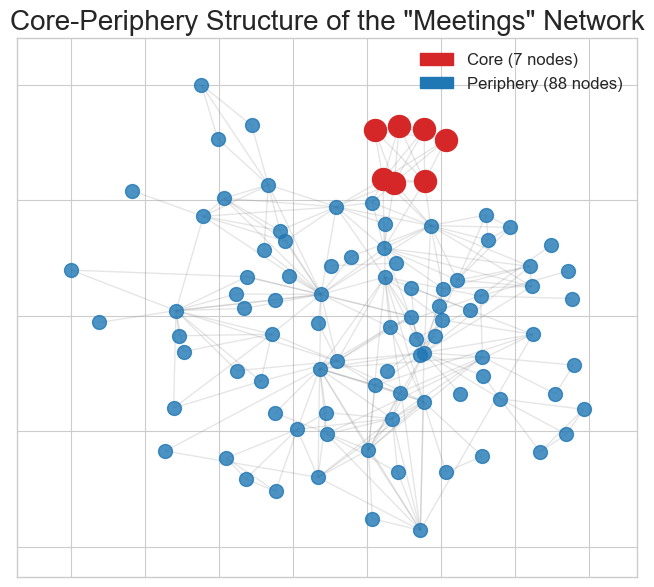

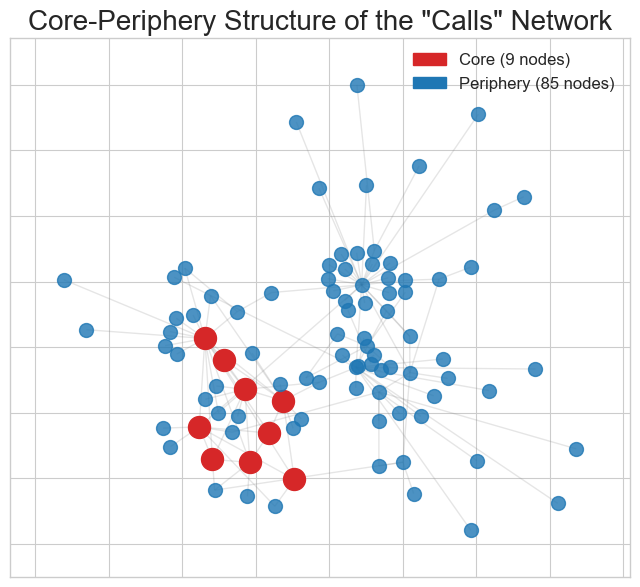

In [56]:
# Plot the core-periphery structure of the network
def plot_core_periphery(G, df_core, network_name):
    
    if df_core is None:
        return
        
    # Get the list of core and periphery nodes
    core_nodes = df_core[df_core['Structure'] == 'Core']['Node'].tolist()
    periphery_nodes = df_core[df_core['Structure'] == 'Periphery']['Node'].tolist()
    
    # Use a layout that shows structure well
    pos = nx.kamada_kawai_layout(G)
    
    # Drawing
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(8, 7))
    
    # Draw edges first
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, node_color='#d62728', node_size=250, label='Core')
    nx.draw_networkx_nodes(G, pos, nodelist=periphery_nodes, node_color='#1f77b4', node_size=100, alpha=0.8, label='Periphery')
    
    plt.title(f'Core-Periphery Structure of the "{network_name}" Network', fontsize=20)
    
    # Create legend
    legend_patches = [
        mpatches.Patch(color='#d62728', label=f'Core ({len(core_nodes)} nodes)'),
        mpatches.Patch(color='#1f77b4', label=f'Periphery ({len(periphery_nodes)} nodes)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', fontsize=12)
    
    plt.show()


# Visualize Meetings network
if df_core_meetings is not None:
    plot_core_periphery(G_meetings, df_core_meetings, "Meetings")

# Visualize Calls network
if df_core_calls is not None:
    plot_core_periphery(G_calls, df_core_calls, "Calls")


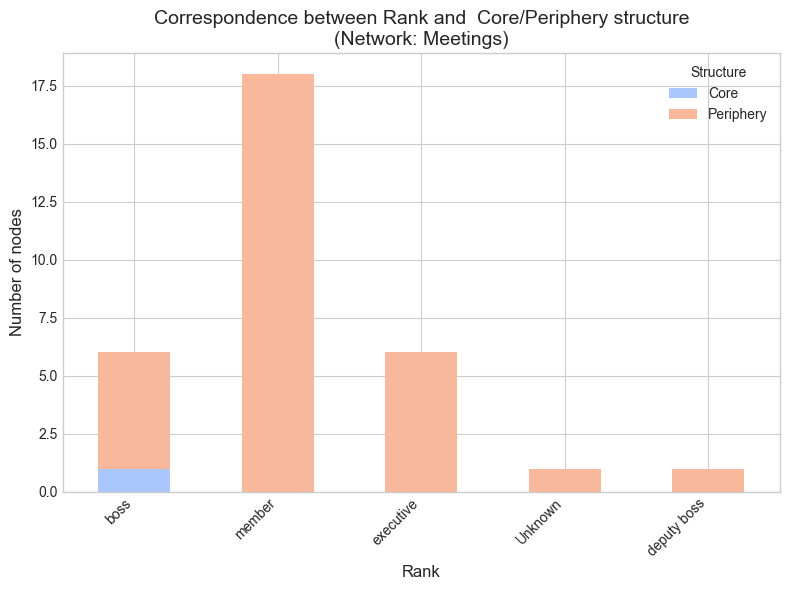

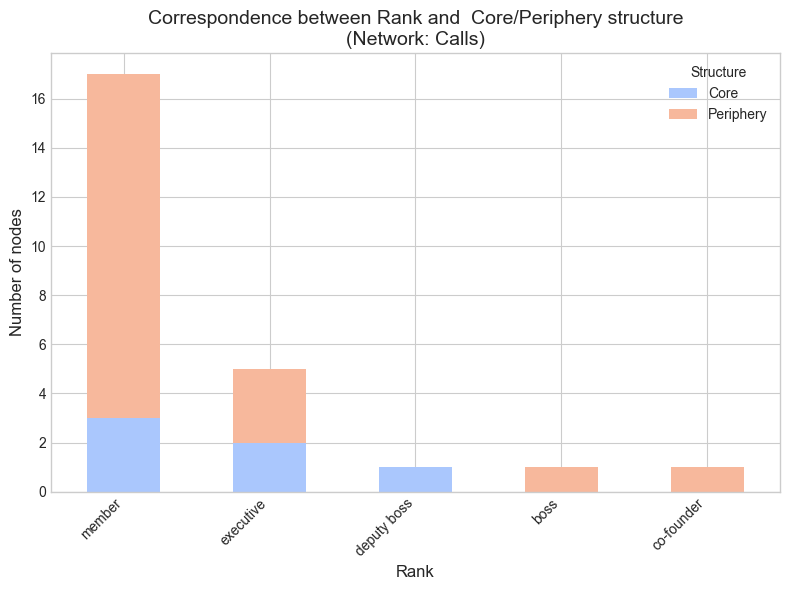

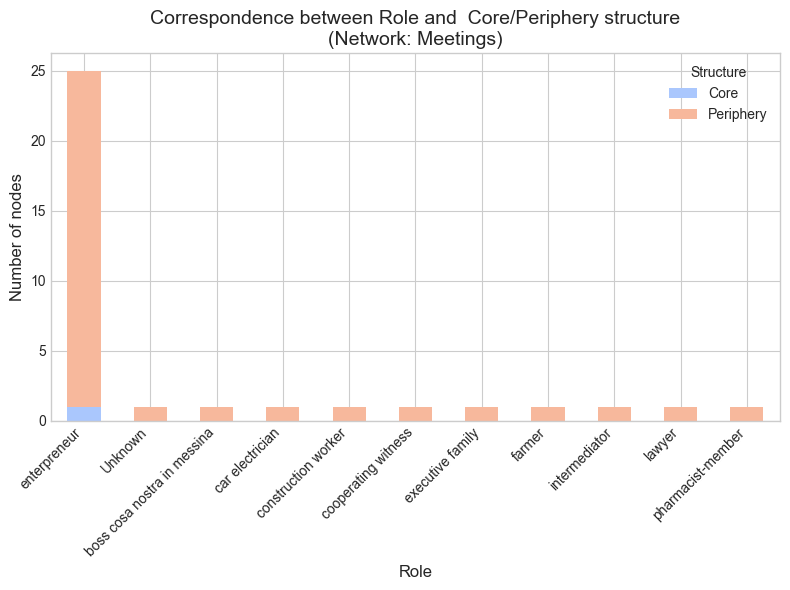

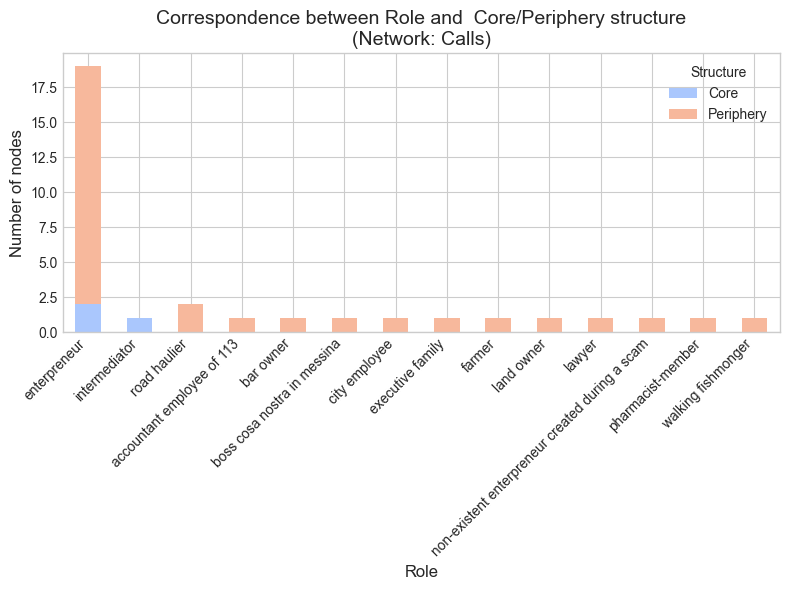

In [57]:


def plot_correspondence(df_analysis, column_name, network_name, top_n=15):
    
    # Rimuovi valori non definiti o generici per pulire il grafico
    df_filtered = df_analysis
    

    # Raggruppa i dati per la colonna specificata e per 'Structure', poi conta i nodi
    df_grouped = df_filtered.groupby([column_name, 'Structure']).size().unstack(fill_value=0)
    
    if 'Core' not in df_grouped:
        df_grouped['Core'] = 0
    if 'Periphery' not in df_grouped:
        df_grouped['Periphery'] = 0

    # Order by the total number of nodes in each category
    df_grouped = df_grouped.sort_values(by=['Core', 'Periphery'], ascending=False)

    # Create plot
    ax = df_grouped.plot(kind='bar', stacked=True, figsize=(8, 6), 
                         color=sns.color_palette("coolwarm", 2))

    
    plt.title(f'Correspondence between {column_name} and  Core/Periphery structure\n(Network: {network_name})', fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Number of nodes', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Structure')
    plt.tight_layout() 
    
    plt.show()




# Rank Analysis

plot_correspondence(df_core_meetings, 'Rank', 'Meetings')
plot_correspondence(df_core_calls, 'Rank', 'Calls')

# Role Analysis

plot_correspondence(df_core_meetings, 'Role', 'Meetings')
plot_correspondence(df_core_calls, 'Role', 'Calls')

### Small-Worldness

Note:
A Small-World network is a type of network that, like many real social networks (including the mafia), combines two seemingly contradictory characteristics:
- High Local Cohesion: Nodes tend to form very cohesive groups, where everyone knows each other.
- High global efficiency: Despite the group structure, anyone else in the network can be reached through a surprisingly low number of steps.

Generally, a network is considered small-world if it has a high clustering coefficient and a low average shortest path. We already have the data, we need to compare it with something. One possible approach would be to compare it with the same data resulting from randomly generated networks (with the same number of nodes and arcs).
To be a small-world network, we would expect a higher clustering coefficient than a random network and a similar average shortest path.

A small *ASP* shows that the network is efficient (information is exchanged quickly), while *high clustering* shows that it is resilient and secure (information may be restricted to individual clusters, so if you shut down one at random, you achieve little). If it is a *small world* (both conditions true), it indicates that it is difficult to dismantle the network. For example, if the meetings network is small, it could mean that the most important meetings and exchanges take place in person. If both are small, it shows us that they are both well structured.

In [58]:
#DEBUG 

# Calculate the small-world coefficient sigma (if sigma > 1, the network is small-world)
def calculate_small_world_sigma(G, niter=100, seed=None):
   
    
    if not nx.is_connected(G): # Our graph is diconnected so we use the LCC
        
        lcc_nodes = max(nx.connected_components(G), key=len)
        G = G.subgraph(lcc_nodes).copy()

    n = G.number_of_nodes()
    m = G.number_of_edges()

    # Calculate the real metrics
    CC_real = nx.average_clustering(G)
    SPL_real = nx.average_shortest_path_length(G)

    # Initialize lists to store random metrics
    CC_rand_list = []
    SPL_rand_list = []
    
    # Generate n random networks (n = niter)
    for i in range(niter):
        # Generate a random graph with the same number of nodes and edges (changing the seed for each iteration)
        G_rand = nx.gnm_random_graph(n, m, seed=(seed + i) if seed is not None else None)
        
        if not nx.is_connected(G_rand):
            
            lcc_nodes_rand = max(nx.connected_components(G_rand), key=len)
            if len(lcc_nodes_rand) > 3: # Check if the LCC is not trivial (not enough nodes)
                G_rand = G_rand.subgraph(lcc_nodes_rand).copy()
            else:
                continue 
        
        CC_rand_list.append(nx.average_clustering(G_rand))
        SPL_rand_list.append(nx.average_shortest_path_length(G_rand))

    # Calculate the average of the random metrics
    CC_rand_avg = np.mean(CC_rand_list)
    SPL_rand_avg = np.mean(SPL_rand_list)

    # Calculate the single ratios

    # Clustering coefficient ratio
    CC_ratio = CC_real / CC_rand_avg
    
    # Shortest path length ratio
    SPL_ratio = SPL_real / SPL_rand_avg
    
    # Calculate small-world coefficient sigma
    # Se il clustering è molto più alto (gamma >> 1) e il cammino è simile (lambda ≈ 1), sigma sarà > 1.
    sigma = CC_ratio / SPL_ratio
    
    return {
        'sigma': sigma,
        'clustering_ratio': CC_ratio,
        'shortest_path_length_ratio': SPL_ratio,
        'CC_real': CC_real,
        'CC_rand_avg': CC_rand_avg,
        'SPL_real': SPL_real,
        'SPL_rand_avg': SPL_rand_avg
    }


# Calculate for the network Meetings
sw_meetings = calculate_small_world_sigma(G_meetings, seed=42)
print("--- Small-World analysis for the network 'Meetings' ---")
for key, value in sw_meetings.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}")
if sw_meetings['sigma'] > 1:
    print("\n==> The Meetings network has Small-World properties")
else:
    print("\n==> The Meetings network doesn't have Small-World properties")

print("\n" + "="*50 + "\n")

# Calculate for the network Calls
sw_calls = calculate_small_world_sigma(G_calls, seed=42)
print("--- Small-World analysis for the network 'Calls' ---")
for key, value in sw_calls.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}")
if sw_calls['sigma'] > 1:
    print("\n==> The Calls network has Small-World properties")
else:
    print("\n==> The Calls network doesn't have Small-World properties")

--- Small-World analysis for the network 'Meetings' ---
Sigma: 9.6780
Clustering Ratio: 11.0041
Shortest Path Length Ratio: 1.1370
Cc Real: 0.7039
Cc Rand Avg: 0.0640
Spl Real: 3.1070
Spl Rand Avg: 2.7326

==> The Meetings network has Small-World properties


--- Small-World analysis for the network 'Calls' ---
Sigma: 5.3735
Clustering Ratio: 4.1623
Shortest Path Length Ratio: 0.7746
Cc Real: 0.1050
Cc Rand Avg: 0.0252
Spl Real: 3.3325
Spl Rand Avg: 4.3022

==> The Calls network has Small-World properties


#### Degree distribution

Note: this section was done mostly to get the graphs of the degree distribution. An attempt to fit the distribution to the power law / lognormal was made, but nothing of particular notice was found. In synthesys:

α = 2.30 for phone calls is consistent with the presence of a few hub-like actors dominating communications.
α = 4.78 for meetings suggests a more 'homogeneous' connectivity without prominent hubs.
However, likelihood ratio tests did not find a significant difference between power-law and lognormal fits, so these results should be interpreted as descriptive (and luckily, it fits with what we found) rather than conclusive.

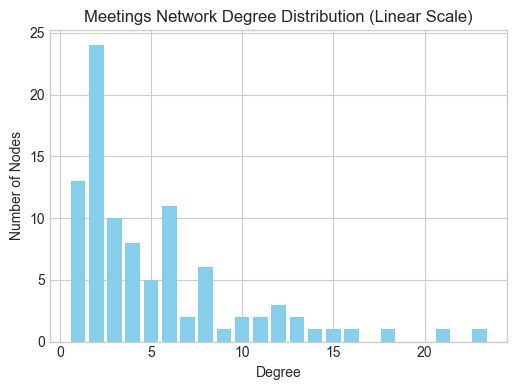

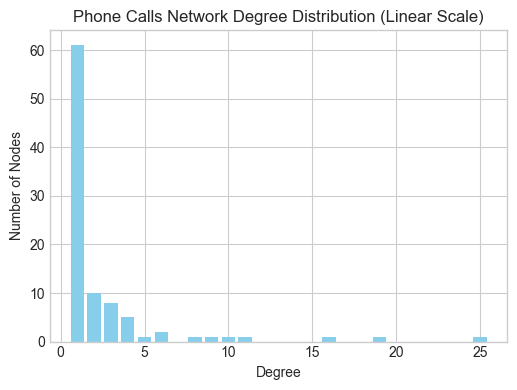

In [59]:
from collections import Counter

def plot_degree_distribution(G, title='Degree Distribution'):
    # Get degree for each node
    degrees = [d for _, d in G.degree()]
    
    # Count frequency of each degree
    degree_counts = Counter(degrees)
    deg, cnt = zip(*sorted(degree_counts.items()))

    # Plot degree distribution (linear scale)
    plt.figure(figsize=(10, 4))
    
    # Linear scale
    plt.subplot(1, 2, 1)
    plt.bar(deg, cnt, width=0.80, color='skyblue')
    plt.title(f'{title} (Linear Scale)')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    plt.tight_layout()
    plt.show()

plot_degree_distribution(G_meetings, title='Meetings Network Degree Distribution')
plot_degree_distribution(G_calls, title='Phone Calls Network Degree Distribution')

Fitting power law to Meetings network:
Calculating best minimal value for power law fit
Power-law alpha: 4.7815
Power-law xmin: 12.0
Loglikelihood ratio test (vs lognormal): R = -0.1939, p = 0.6522


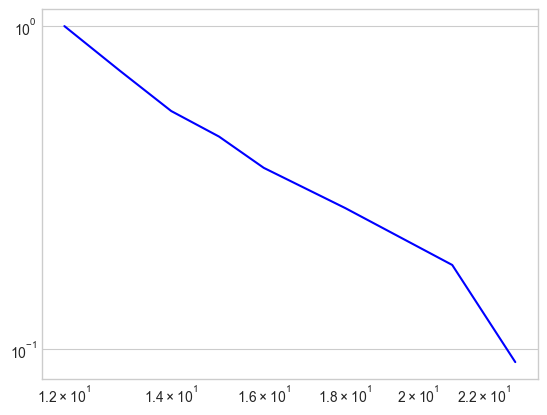

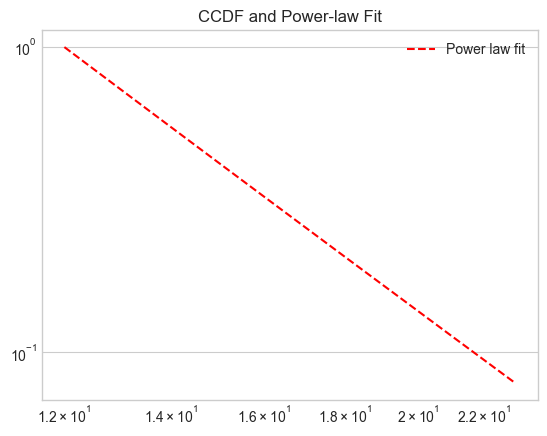

Fitting power law to Calls network:
Calculating best minimal value for power law fit
Power-law alpha: 2.2957
Power-law xmin: 3.0
Loglikelihood ratio test (vs lognormal): R = -0.2564, p = 0.5210


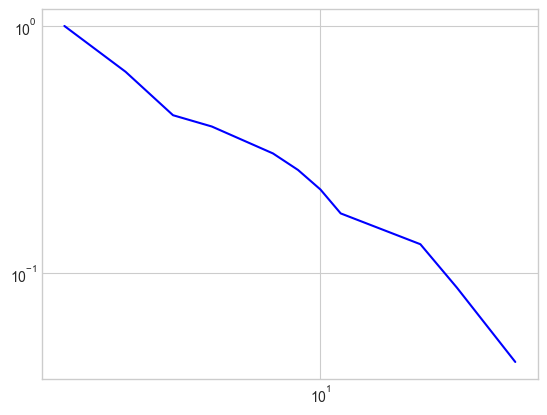

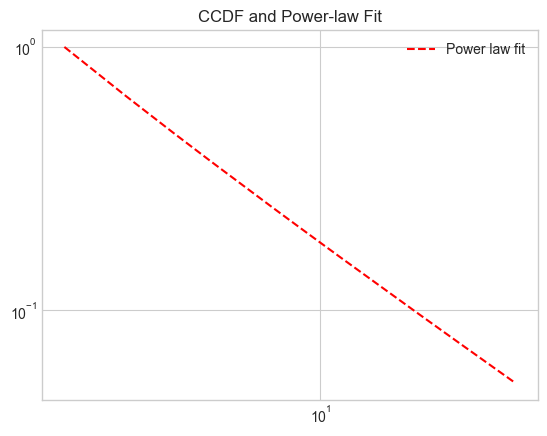

In [ ]:
import powerlaw # pip install powerlaw

def fit_power_law(G):
    degrees = [d for _, d in G.degree()]
    fit = powerlaw.Fit(degrees, discrete=True)
    print(f"Power-law alpha: {fit.power_law.alpha:.4f}")
    print(f"Power-law xmin: {fit.power_law.xmin}")
    R, p = fit.distribution_compare('power_law', 'lognormal')
    print(f"Loglikelihood ratio test (vs lognormal): R = {R:.4f}, p = {p:.4f}")
    fit.plot_ccdf(color='blue', label='Empirical')
    fit.power_law.plot_ccdf(color='red', linestyle='--', label='Power law fit')
    plt.legend()
    plt.title('CCDF and Power-law Fit')
    plt.show()

# Example:
print("Fitting power law to Meetings network:")
fit_power_law(G_meetings)
print("Fitting power law to Calls network:")
fit_power_law(G_calls)